In [2]:
%matplotlib inline
%load_ext tensorboard
!pip install -q h5py pyyaml
!pip install -q tensorflow==2.0.0-beta1
#!pip install -q tensorflow==1.14
from __future__ import absolute_import, division, print_function, unicode_literals
import sys, os, datetime, time, scipy, re, csv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from scipy import stats
from scipy.integrate import quad
from google.colab import drive
from os import listdir
import matplotlib.patches as patches
from os.path import isfile, join
from sklearn import preprocessing
import IPython
drive.mount('/content/gdrive', force_remount=True)
# %cd /content/gdrive/My\ Drive/Colab\ Notebooks/zhiming
!pip show tensorflow
print("tf.executing_eagerly():", tf.executing_eagerly())
# from tensorflow.python.keras import backend as K

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Mounted at /content/gdrive
Name: tensorflow
Version: 2.0.0b1
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.6/dist-packages
Requires: tf-estimator-nightly, absl-py, six, astor, keras-applications, gast, google-pasta, protobuf, wheel, termcolor, grpcio, tb-nightly, wrapt, numpy, keras-preprocessing
Required-by: stable-baselines, magenta, fancyimpute
tf.executing_eagerly(): True


In [3]:
%cd /content/gdrive/My\ Drive/Colab\ Notebooks/zhiming
!ls

/content/gdrive/My Drive/Colab Notebooks/zhiming
best
errors_best.txt
initials
model_benchmark_relative_errors_0.02119291809884263.h5
model_best.h5
model_bottom_errm_0.0034.h5
model_bottom_errm_0.0037.h5
model_bottom_errm_0.0039.h5
model_bottom_errm_0.0041.h5
model_bottom_errm_0.0042.h5
model_bottom_errm_0.0045.h5
model_bottom_errm_0.0046.h5
model_bottom_errm_0.0049.h5
model_bottom_errm_0.0055.h5
model_bottom_errm_0.0057.h5
model_bottom_errm_0.0067.h5
model_bottom_errm_0.0070.h5
model_bottom_errm_0.0077.h5
model_bottom_errm_0.0108.h5
model_bottom_errm_0.0248.h5
model_top_errm_0.0091.h5
model_top_errm_0.0099.h5
model_top_errm_0.0100.h5
model_top_errm_0.0106.h5
model_top_errm_0.0109.h5
model_top_errm_0.0119.h5
model_top_errm_0.0130.h5
model_top_errm_0.0134.h5
model_top_errm_0.0142.h5
model_top_errm_0.0149.h5
model_top_errm_0.0151.h5
model_top_errm_0.0155.h5
model_top_errm_0.0164.h5
model_top_errm_0.0165.h5
model_top_errm_0.0210.h5
model_top_errm_0.0235.h5
model_top_errm_0.0255.h5
path1
p

### Data processing

The raw data is a 90 by 66 matrix with first row as `omega` for speed and first colum as `tao` for torque. 

It is rearraged into a 89x65 = 5785 elements list, each element has x1=omega, x2=tau, y.

In [0]:
def get_data_from_csv(file_name):
  data_raw = []
  with open(file_name, newline='', encoding='utf-8-sig') as csvfile:
    content = csv.reader(csvfile, delimiter=' ', quotechar='|')
    for row in content:
      data_raw.append(row)
  csvfile.close()
  data_raw = data_raw[:-1]
  #print("read", len(data_raw), "rows from csv file")

  # get omega/x1
  x1_range = [x.strip() for x in data_raw[0][0].split(',')][1:-1]
  x1_range = [float(i) for i in x1_range]
  #print(len(x1_range), "omegas:", x1_range)


  # get tao/x2
  x2_range = [i[0].split(',')[0] for i in data_raw][1:]
  x2_range = [float(i) for i in x2_range if len(i)!=0]
  #print(len(x2_range), "taos:", x2_range)

  # get y
  t = [i[0].split(',') for i in data_raw]
  t.pop(0) # remove first row
  t = [r[1:] for r in t] # remove first column
  
  # pick out valid y
  x1=[]; x2=[]; y=[]; y_matrix = np.ones(shape=(len(x2_range), len(x1_range)))
  x1_nn=[]; x2_nn=[]; y_nn=[]
  for i in range(len(x2_range)):
    for j in range(len(x1_range)):
      tmp = np.nan if t[i][j] == '' else float(t[i][j])
      x1.append(float(x1_range[j]))
      x2.append(float(x2_range[i]))
      y.append(tmp)
      y_matrix[i][j] = tmp
      
      if t[i][j] != '':
        x1_nn.append(float(x1_range[j]))
        x2_nn.append(float(x2_range[i]))
        y_nn.append(tmp)
  
  return x1_nn, x2_nn, y_nn, x1, x2, y, x1_range, x2_range, y_matrix

def plot_contour(y_matrix, x1_range, x2_range, title=''):
  x1, x2 = np.meshgrid(x1_range, x2_range)
  fig = plt.figure(figsize=(10, 8), dpi=80)
  ax = fig.add_subplot(111)
  
  levels = np.arange(-0.5, 0.5, 0.01)
  #cpf = ax.contourf(x1, x2, y_matrix, 25, cmap='hsv')
  cpf = ax.contourf(x1, x2, y_matrix, levels, cmap='hsv')
  colours = ['w' if level<0 else 'k' for level in cpf.levels]
  cp = ax.contour(x1, x2, y_matrix, colors=colours)
  # ax.clabel(cp, fontsize=12, colors=colours)
  plt.colorbar(cpf, fraction=.1, pad=0.01)
  plt.title(title)
  plt.show()
  
#plot_contour(errors_matrix, x1_range, x2_range, title='absolute errors')

data size for training: 4649


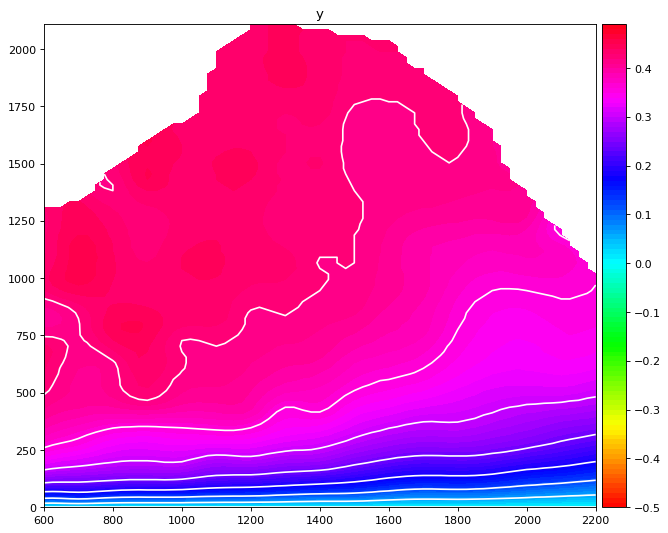

In [22]:
x1_nn, x2_nn, y_nn, x1, x2, y, x1_range, x2_range, y_matrix = get_data_from_csv('zhiming_irreg.csv')
print("data size for training:", len(y_nn))
plot_contour(y_matrix, x1_range, x2_range, title='y')

### Benchmark Errors (MSE only)

In [0]:
def merge_x1_x2(x1, x2):
  x = [[i, j] for i, j in zip(x1, x2)]
  x = np.array(x)
  x = preprocessing.scale(x)
  return x
      
def train_model_bottom(x, y, epochs=1000):
  def custom_loss(y_true, y_pred):
    return tf.reduce_mean(tf.pow(y_true - y_pred, 4))
  model = tf.keras.Sequential([
          tf.keras.layers.Dense(10, activation='relu', input_shape=(2, ), name='a'),
          tf.keras.layers.Dense(10, activation='relu'),
          tf.keras.layers.Dense(1, name='b')])
  optimizer = tf.keras.optimizers.RMSprop(0.01)
  model.compile(loss=custom_loss, optimizer=optimizer)
  #model.compile(loss='mse', optimizer=optimizer)
  
  es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, verbose=0)
  history = model.fit(x, y, batch_size = 1, epochs=epochs, validation_split = 0.2, verbose=0, callbacks=[es])
  return model, history

def train_model_top(x, y, epochs=2):
  model = tf.keras.Sequential([
          tf.keras.layers.Dense(5, activation='tanh', input_shape=(2, ), name='a'),
          tf.keras.layers.Dense(1, name='b')])
  optimizer = tf.keras.optimizers.Adam(0.01)
  model.compile(loss='mse',optimizer=optimizer)
  
  es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, verbose=0)
  history = model.fit(x, y, batch_size = 1, epochs=epochs, validation_split = 0.2, verbose=0, callbacks=[es])
  return model, history

def get_x1x2y_from_ymatrix(ymatrix):
  x1=[]; x2=[]; y=[]
  for i in range(ymatrix.shape[0]):
    for j in range(ymatrix.shape[1]):
      if np.isnan(ymatrix[i][j])==False:
        x1.append(600+j*25)
        x2.append(i*24.2)
        y.append(ymatrix[i][j])
  return x1, x2, y

def get_benchmark_NN(i_max=100,  bottom=True):
  x1_nn, x2_nn, y_nn, x1, x2, y, x1_range, x2_range, y_matrix= get_data_from_csv('zhiming_irreg.csv')
  
  # separate data for bottom and top, x1<1500 and x2<169.7 is bottom model, otherwise is top model
  x1idx=65 
  x2idx=6 
  
  print("the bottom part is tao =<", x2_range[x2idx-1], "and omega =<", x1_range[x1idx-1])
  
  mask_bottom = np.zeros_like(y_matrix)
  mask_bottom[:x2idx, :x1idx] = 1
  mask_top = 1 - mask_bottom
    
  if bottom: x1, x2, y = get_x1x2y_from_ymatrix(y_matrix)
  else: x1, x2, y = get_x1x2y_from_ymatrix(y_matrix)
  
  x = merge_x1_x2(x1, x2) 
  i=0
  mean_min=1

  while True:
    i+=1
    if bottom: model, history = train_model_bottom(x, y)
    else: model, history = train_model_top(x, y)
      
    y_pred = model.predict(x)
    errors = y_pred.reshape(-1) - y
    # use relative errors when possible
    for i in range(len(errors)):
      if y[i]!=0:
        errors[i] = errors[i]/y[i]
    #
    errors = [np.abs(err) for err in errors]
    mean = np.mean(errors)
    print(i, ":", mean)
    
    if mean<mean_min: 
      mean_min = mean
      model_best = model
      history_best = history
      errors_best = errors
      
    if mean<0.002 or i>i_max:
      break
  
  print("lowest errors mean: ", mean_min)
  if bottom:
    file_name = "model_bottom_errm_" + str(mean_min)[:6] +".h5"
  else:
    file_name = "model_top_errm_" + str(mean_min)[:6] +".h5"
  model_best.save(file_name)
  return model_best, mask_bottom

# tf.keras.models.load_model(file_name)

def get_errors_matrix(model_bottom, model_top, y_matrix, mask_bottom):
  errors_matrix = np.zeros_like(y_matrix)
  errors_rel_matrix = np.zeros_like(y_matrix)
  
  # fill up bottom errors
  x1, x2, y = get_x1x2y_from_ymatrix(y_matrix)
  x = merge_x1_x2(x1, x2)
  idx = np.arange(len(x1))
  x1 = np.asarray(x1)
  x2 = np.asarray(x2)
  xs = np.stack([idx, x1, x2], axis=1)
  for i in range(y_matrix.shape[0]):
    for j in range(y_matrix.shape[1]):
      if np.isnan(y_matrix[i][j]):
        errors_matrix[i][j] = np.nan
        errors_rel_matrix[i][j] = np.nan
      else:
        cond1 = 600+25*j
        cond2 = 24.2*i
        idxs = xs[(np.where((xs[:,1] == cond1 ) & (xs[:,2] == cond2)))]
        idxs = np.squeeze(idxs)
        x_idx = idxs[0]
        x_idx = int(x_idx)
        xi = np.expand_dims(x[x_idx], axis=0)
        
        if mask_bottom[i][j]==1: 
          #err = model_bottom.predict(xi) - y_matrix[i][j]
          #print("cond1:", cond1, "cond2:", cond2)
          y_pred_bottom = model_bottom.predict(xi)
          # y_pred_top = model_top.predict(xi)
          # err = 0.5*(y_pred_bottom+y_pred_top) - y_matrix[i][j]
          err = y_pred_bottom - y_matrix[i][j]
          
        else: 
          err = model_top.predict(xi) - y_matrix[i][j]
          
        errors_matrix[i][j] = np.abs(err)
        if y_matrix[i][j]!=0:
          errors_rel_matrix[i][j] = np.abs(err)/y_matrix[i][j]

  return errors_matrix, errors_rel_matrix

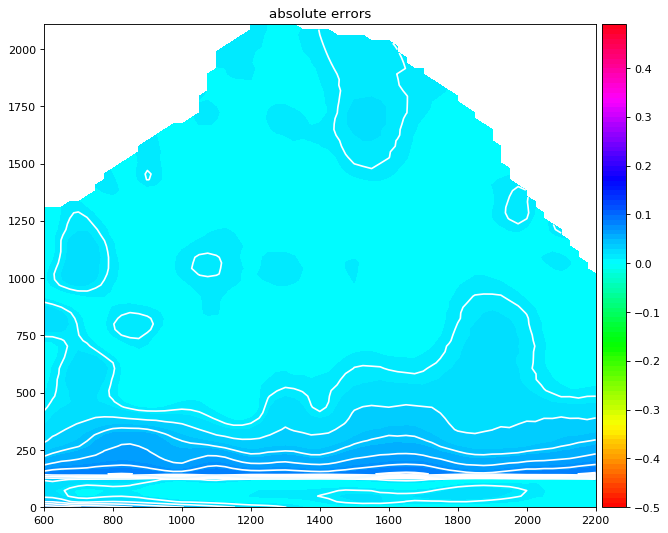

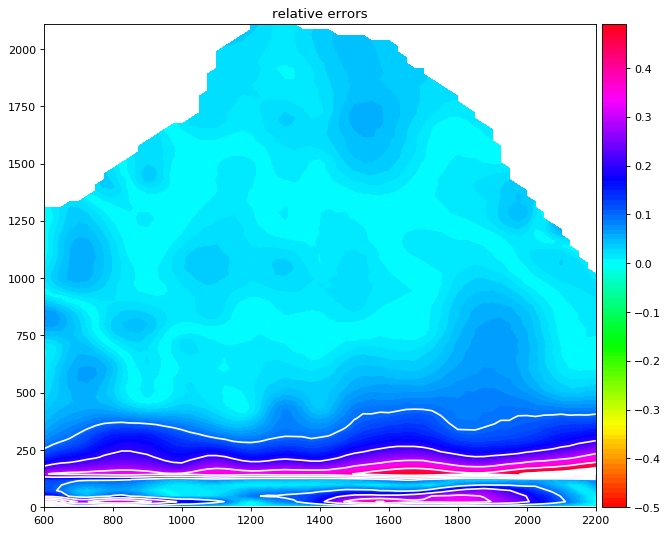

mean relative errors 0.05578612321304616
min relative errors 0.0
max relative errors 0.647003173828125
mean absolute errors 0.016050679678092157
min absolute errors 1.1742115020751953e-05
max absolute errors 0.09325219690799713


In [30]:
x1_nn, x2_nn, y_nn, x1, x2, y, x1_range, x2_range, y_matrix= get_data_from_csv('zhiming_irreg.csv')
model_bottom, mask_bottom = get_benchmark_NN(i_max=20,  bottom=True)
model_top, _ = get_benchmark_NN(i_max=5,  bottom=False)

#model_top = tf.keras.models.load_model('model_top_errm_0.0091.h5')

errors_matrix, errors_rel_matrix = get_errors_matrix(model_bottom, model_top, y_matrix, mask_bottom)
plot_contour(errors_matrix, x1_range, x2_range, title='absolute errors')
plot_contour(errors_rel_matrix, x1_range, x2_range, title='relative errors')

a = []
for i in errors_rel_matrix:
  for j in i:
    if np.isnan(j)==False: a.append(j)
      
print("mean relative errors", np.mean(a))
print("min relative errors", np.min(a))
print("max relative errors", np.max(a))

a = []
for i in errors_matrix:
  for j in i:
    if np.isnan(j)==False: a.append(j)
      
print("mean absolute errors", np.mean(a))
print("min absolute errors", np.min(a))
print("max absolute errors", np.max(a))

mean relative errors 0.03579983414936493
min relative errors -0.4100441038608551
max relative errors 0.647003173828125
mean absolute errors 0.01100490463284183
min absolute errors -0.028586506843566895
max absolute errors 0.09325219690799713


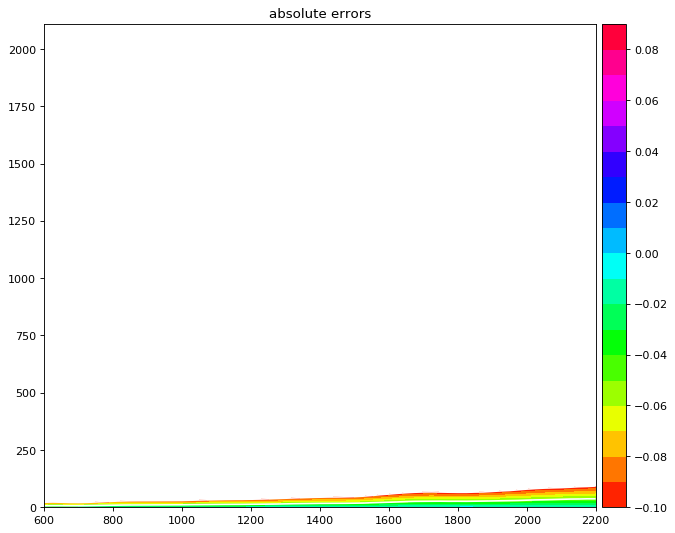

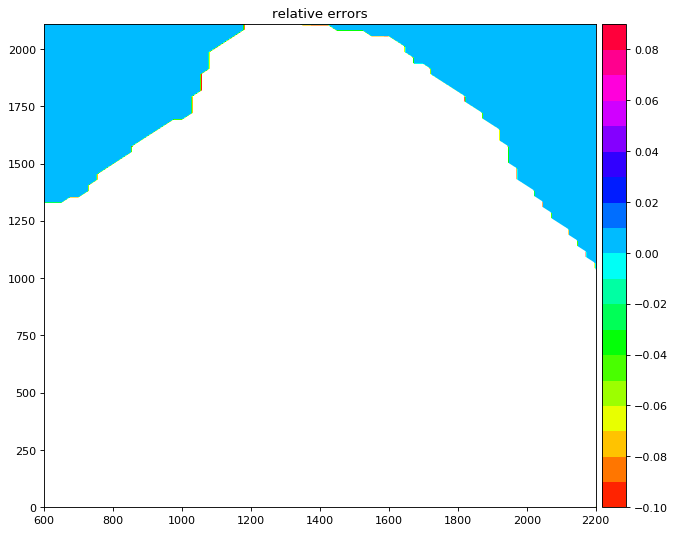

In [192]:
def get_errors_matrix(model, y_matrix):
  errors_matrix = np.zeros_like(y_matrix)
  errors_rel_matrix = np.zeros_like(y_matrix)
  
  # fill up bottom errors
  x1, x2, y = get_x1x2y_from_ymatrix(y_matrix)
  x = merge_x1_x2(x1, x2)
  idx = np.arange(len(x1))
  x1 = np.asarray(x1)
  x2 = np.asarray(x2)
  xs = np.stack([idx, x1, x2], axis=1)
  for i in range(y_matrix.shape[0]):
    for j in range(y_matrix.shape[1]):
      if np.isnan(y_matrix[i][j]):
        errors_matrix[i][j] = np.nan
      else:
        cond1 = 600+25*j
        cond2 = 24.2*i
        idxs = xs[(np.where((xs[:,1] == cond1 ) & (xs[:,2] == cond2)))]
        idxs = np.squeeze(idxs)
        x_idx = idxs[0]
        x_idx = int(x_idx)
        xi = np.expand_dims(x[x_idx], axis=0)
   
        y_pred_bottom = model_bottom.predict(xi)
        err = y_pred_bottom - y_matrix[i][j]

          
        errors_matrix[i][j] = err
        if y_matrix[i][j]!=0:
          errors_rel_matrix[i][j] = err/y_matrix[i][j]

  return errors_matrix, errors_rel_matrix

model = tf.keras.models.load_model('model_benchmark_relative_errors_0.02119291809884263.h5')
errors_matrix, errors_rel_matrix = get_errors_matrix(model, y_matrix)
plot_contour(errors_matrix, x1_range, x2_range, title='absolute errors')
plot_contour(errors_rel_matrix, x1_range, x2_range, title='relative errors')

In [194]:
errors_rel_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-1.29244137, -1.295488  , -1.27602303, ..., -1.27451968,
        -1.29583359, -1.34150004],
       [-1.11362016, -1.12631345, -1.12982094, ..., -1.08205748,
        -1.10367417, -1.12458491],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

read 89 rows from csv file
65 omegas: [600.0, 625.0, 650.0, 675.0, 700.0, 725.0, 750.0, 775.0, 800.0, 825.0, 850.0, 875.0, 900.0, 925.0, 950.0, 975.0, 1000.0, 1025.0, 1050.0, 1075.0, 1100.0, 1125.0, 1150.0, 1175.0, 1200.0, 1225.0, 1250.0, 1275.0, 1300.0, 1325.0, 1350.0, 1375.0, 1400.0, 1425.0, 1450.0, 1475.0, 1500.0, 1525.0, 1550.0, 1575.0, 1600.0, 1625.0, 1650.0, 1675.0, 1700.0, 1725.0, 1750.0, 1775.0, 1800.0, 1825.0, 1850.0, 1875.0, 1900.0, 1925.0, 1950.0, 1975.0, 2000.0, 2025.0, 2050.0, 2075.0, 2100.0, 2125.0, 2150.0, 2175.0, 2200.0]
88 taos: [0.0, 24.2, 48.5, 72.7, 97.0, 121.2, 145.4, 169.7, 193.9, 218.2, 242.4, 266.6, 290.9, 315.1, 339.4, 363.6, 387.8, 412.1, 436.3, 460.6, 484.8, 509.1, 533.3, 557.5, 581.8, 606.0, 630.3, 654.5, 678.7, 703.0, 727.2, 751.5, 775.7, 799.9, 824.2, 848.4, 872.7, 896.9, 921.1, 945.4, 969.6, 993.9, 1018.1, 1042.3, 1066.6, 1090.8, 1115.1, 1139.3, 1163.5, 1187.8, 1212.0, 1236.3, 1260.5, 1284.8, 1309.0, 1333.2, 1357.5, 1381.7, 1406.0, 1430.2, 1454.4, 1478.7,

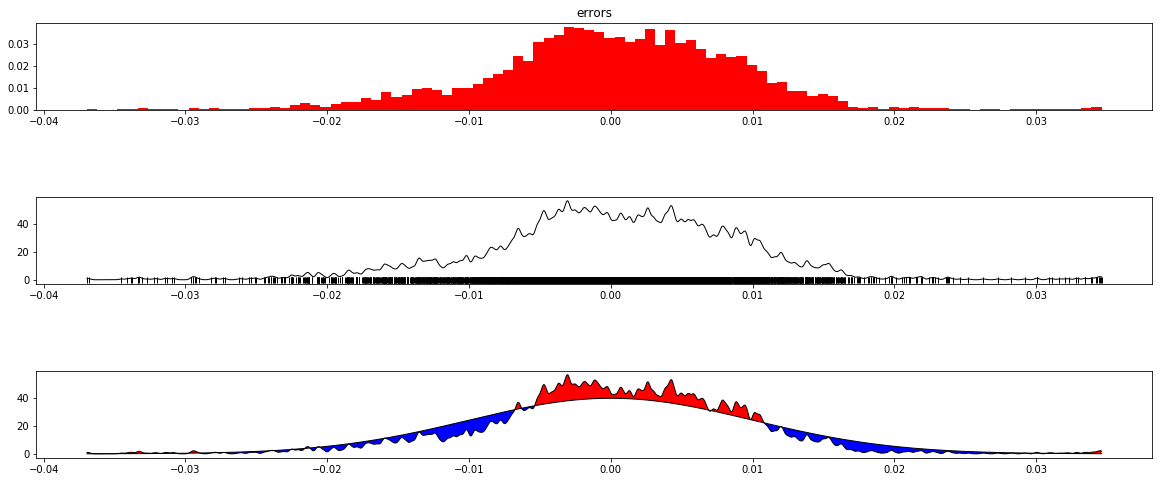

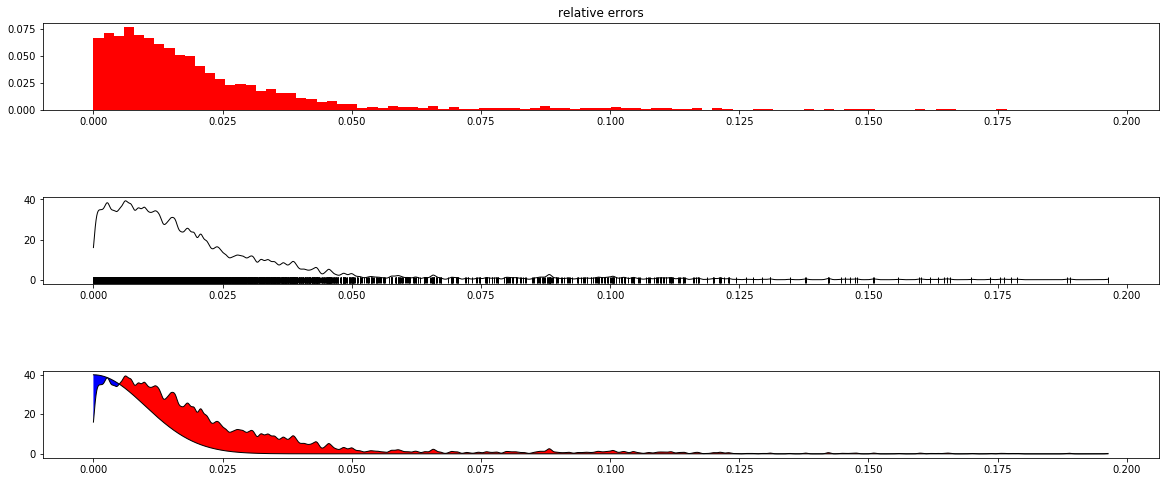

In [0]:
file_name = 'model_benchmark_relative_errors_0.02119291809884263.h5'
model = reload_model(file_name)
x1, x2, y, _, _, _, _, _, _ = get_data_from_csv('zhiming_irreg.csv')
x = merge_x1_x2(x1, x2)
errors, errors_rel = get_errors(model, x, y)

print("\nerrors mean", np.mean(errors))
print("errors variance", np.var(errors))

print("\nerrors_rel mean", np.mean(errors_rel))
print("errors_rel variance", np.var(errors_rel))

print("\nerrors_rel mean middle part", np.mean(errors_rel[300:3800]))
print("errors_rel variance middle part", np.var(errors_rel[300:3800]))

plot_errors(errors, target_sigma=0.01, title='errors')
plot_errors(errors_rel, target_sigma=0.01, title='relative errors')


### Benchmark Loss (Target Normal) and Gradient

In [0]:
def get_loss_kde(errors, target_sigma, if_plot=False):
  kde = get_kde(errors)
  dists=[]; density_norms=[]; density_kdes=[]
  errors = np.sort(errors)
  for err in errors:
    
    density_norm=scipy.stats.norm(0, target_sigma).pdf(err)
    density_kde = kde(err)
    dist = np.abs(density_norm-density_kde)
    dists.append(dist)
    density_norms.append(density_norm)
    density_kdes.append(density_kde)
    
  if if_plot:
    plt.figure(figsize=(10, 4), dpi=80)
    title="target sigma = " + str(target_sigma)
    plt.title(title)
    plt.plot(errors, density_norms, label="norms")
    plt.plot(errors, density_kdes, label="kdes")
    
  return np.mean(dists)

def get_loss_kde_include_mse(errors, target_sigma, if_plot=False):
  dist = get_loss_kde(errors, target_sigma, if_plot=if_plot)
  sd = np.sqrt(np.var(errors))
  return dist*sd, dist, sd

def node_plus_delta(model, node_n, delta):
  nodes_n_in_layer_0 = 5
  if 0<=node_n<=(nodes_n_in_layer_0-1): 
    weights = model.layers[0].trainable_variables[0].numpy()
    #print("\n first layer biases:", weights, ", node_n:", node_n)
    #print(weights)
    weights[0][node_n] += delta
    model.layers[0].trainable_variables[0].assign(weights)
    #print(weights)
    
  elif nodes_n_in_layer_0<=node_n<=(2*nodes_n_in_layer_0-1):
    weights = model.layers[0].trainable_variables[1].numpy()
    #print("\n first layer biases:", weights, ", node_n:", node_n)
    #print(weights)
    weights[node_n-nodes_n_in_layer_0] += delta
    model.layers[0].trainable_variables[1].assign(weights)
    #print(weights)
    
  elif 2*nodes_n_in_layer_0<=node_n<=(3*nodes_n_in_layer_0-1):
    weights = model.layers[1].trainable_variables[0].numpy()
    #print("\n second layer weights:", weights, ", node_n:", node_n)
    #print(weights)
    weights[node_n-2*nodes_n_in_layer_0] += delta
    model.layers[1].trainable_variables[0].assign(weights)
    #print(weights)
    
  elif node_n==3*nodes_n_in_layer_0:
    weights = model.layers[0].trainable_variables[0].numpy()
    #print("\n second layer bias:", weights, ", node_n:", node_n)
    #print(weights)
    weights += delta
    model.layers[0].trainable_variables[0].assign(weights)
    #print(weights)
 
  return model

def node_plus_delta_loss(model, x, y, node_n, delta, target_sigma):
  model = node_plus_delta(model, node_n, delta)
  errors, mean, sigma, _ = get_errors(model, x, y)
  loss = get_loss_kde(errors, target_sigma)
  return loss, model

def get_gradient(model, x, y, target_sigma):
  delta_base = 10**(-6)
  nodes_n_in_layer_0 = 5
  grads = []; delta_steps_all = []
  for i in range(3*nodes_n_in_layer_0 + 1):
    delta_steps = 0
    while True:
      delta_steps += 1
      delta = delta_steps*10**(-6)
      plus_loss, _ = node_plus_delta_loss(model, x, y, i, delta, target_sigma)
      minus_loss, _ = node_plus_delta_loss(model, x, y, i, -delta, target_sigma)
      if plus_loss != minus_loss or delta_steps == 10: break

    numerator = plus_loss - minus_loss
    grad = numerator/(2*delta)
    grads.append(grad)
    delta_steps_all.append(delta_steps)
    #print("delta_steps:", delta_steps, "grad:", grad)

  return grads, delta_steps_all

def update_model(model, grads, delta_steps_all, lr):
  for i in range(len(grads)):
    delta = lr*grads[i]*delta_steps_all[i]
    delta = lr*grads[i]
    #print("i:", i, "delta:", delta)
    model = node_plus_delta(model, i, -delta/2)
  return model

### Training

In [0]:
def plot_errors_from_txt(file_name, title='None'):
  with open(file_name) as f:
    content = f.readlines()
  content = [x.strip() for x in content]    
  content.pop(0)
  errors = [float(x) for x in content] 
  plot_errors(errors, target_sigma=0.001, title=title)
  return errors

def save_txt(file_name, data):
  file = open(file_name, 'w')
  for ers in data:
    file.write("\n")
    file.write(str(ers))
  file.close()
  
def save_model_and_errors_files(subname, model, errors, target_sigma):
  #t = str(datetime.datetime.now().date()) + '_' + str(datetime.datetime.now().time())
  #t = t[11:16]
  model_name = 'model' + subname + '.h5'
  model.save(model_name)
  #print("model saved:", model_name)
  
  bestmodel_filename = 'model_best.h5'
  model.save(bestmodel_filename)

  errors_name = 'errors' + subname + '.txt'
  save_txt(errors_name, errors)
  save_txt('errors_best.txt', errors)
  
def print_result(losses, errors_all, errors_mses, errors_means, target_sigma, model=None):
  print("target_sigma:", target_sigma)
  if model:
    print_model(model)
  xs = np.arange(len(losses))

  plt.figure(dpi=100, figsize=(15, 2))
  plt.xticks(fontsize=10)
  plt.subplots_adjust(wspace=0.25)

  p1 = plt.subplot(131)
  p1.plot(xs, losses)
  plt.xlabel("step")
  plt.ylabel("Loss")
  
  p2 = plt.subplot(132)
  p2.plot(xs, errors_mses)
  plt.xlabel("step")
  plt.ylabel("Errors MSE")

  p3 = plt.subplot(133)
  p3.plot(xs, errors_means)
  plt.xlabel("step")
  plt.ylabel("Errors Mean")
 
  title = "Errors distribution, before training, dist (+mse) loss = " + str(losses[0])
  plot_errors(errors_all[0], target_sigma, title)
  loss_min_index = losses.index(np.min(losses))
  title = "After training of " + str(loss_min_index) + "epochs, loss = " + str(np.min(losses))
  print("loss_min_index:", loss_min_index)
  plot_errors(errors_all[loss_min_index], target_sigma, title)
  
def plot_lists(list_of_lists, title='None'):
  x = np.arange(len(list_of_lists[0]))
  lists_n = len(list_of_lists)
  fig, axs = plt.subplots(1, lists_n, figsize=(20, 2), dpi=80, facecolor='w', edgecolor='k')
  fig.subplots_adjust(hspace = .5, wspace=0.2)
  plt.title(title)
  for i in range(lists_n):
    axs[i].plot(list_of_lists[i])

def plot_hist(x):
  plt.hist(x)
  plt.ylabel("errors")
  plt.title("benchmark NN")
  return 1

def sample_initial_loss(sample_times = 10, data_size = 1000, tsigma=0.001):
  def get_initial_loss(data_size = data_size, tsigma=tsigma):
    #x, y = get_data(data_size)
    x1, x2, y = get_data_from_csv('zhiming.csv')
    x = merge_x1_x2(x1, x2)
    model = get_benchmark_NN(x, y)
    errors, mean, sigma = get_errors(model, x, y, if_print=1)
    benchmark_loss, benchmark_dist_loss, benchmark_sd_loss = get_loss_include_mse(errors, sigma=tsigma)
    return benchmark_loss, benchmark_dist_loss, benchmark_sd_loss
  
  losses=[]; dists=[]; sds=[]
  for i in range(sample_times):
    loss, dist, sd = get_initial_loss(data_size = data_size, tsigma=tsigma)
    losses.append(loss)
    dists.append(dist)
    sds.append(sd)
  
  return losses, dists, sds

def train_dist(step_n=50, if_continue = 1, model=None, lr=10**(-9), tsigma=None):
  # get data
  x1, x2, y, _, _, _, _, _, _ = get_data_from_csv('zhiming_irreg.csv')
  x = merge_x1_x2(x1, x2)
  
  # get model
  if if_continue: 
    model = model
  else: model = get_benchmark_NN(x, y)
    
  # set goal for loss function
  errors, mean, sigma, _ = get_errors(model, x, y)
  
  if if_continue == 0:
    save_txt("errors_initial.txt", errors)
  
  if tsigma: 
    target_sigma = tsigma
  else: target_sigma = sigma/4
  
  benchmark_loss, benchmark_dist_loss, benchmark_sd_loss = get_loss_kde_include_mse(errors, target_sigma)
  print("target_sigma:", target_sigma)
  print("Initial loss:", benchmark_loss, "\n")

  lr_init = lr
  lr = lr_init
  patience_init = 5
  patience = patience_init
  losses=[]; errors_all = []; errors_mses=[]; errors_means=[]; dist_losses=[]; sd_losses=[]
  losses.append(benchmark_loss); errors_mses.append(sigma**2); errors_means.append(mean); errors_all.append(errors)
  for i in range(step_n):
    print("-----Step", i) 
    # estimate gradient and model updates
    grads, deltas = get_gradient(model, x, y, target_sigma)
    
    model = update_model(model, grads, deltas, lr=lr)
    #model = update_model_with_perturbation(model, grads, delta_steps_all=deltas, lr=lr)
    
    # get errors and losses
    errors, mean, sigma, _ = get_errors(model, x, y)
    new_loss, new_dist_loss, new_sd_loss = get_loss_kde_include_mse(errors, target_sigma)
    
    # display results
    print("Loss:", new_loss, ", dist:", new_dist_loss, ", sd:", new_sd_loss, "    (learning rate:", lr, ")")
    print("total improvement:", (losses[0]-new_loss)/losses[0], ", last step improvement:", (losses[-1]-new_loss)/losses[-1])
    print("grads:", grads)
    #print("deltas:", deltas)

    # update patience and learning rate based on pperformence
    if new_loss < np.min(losses): patience = patience_init
    else: 
      patience-= 1;
      grads = [-i for i in grads]
      model = update_model(model, grads, deltas, lr=lr)
      check_errors, _, _, _ = get_errors(model, x, y)
      check_loss, check_dist_loss, check_sd_loss = get_loss_kde_include_mse(check_errors, target_sigma)
      print("Loss is changed back to:", check_loss, ", dist:", check_dist_loss, ", sd:", check_sd_loss, "    (learning rate:", lr, ")")
      
    if new_loss > losses[-1]: lr/=10
    #lr*=0.99
     
    # record results and save model
    losses.append(new_loss)
    dist_losses.append(new_dist_loss)
    sd_losses.append(new_sd_loss)
    errors_mses.append(sigma**2)
    errors_means.append(mean)
    errors_all.append(errors)
    if new_loss == np.min(losses):
      #subname = "_tsig" + str(target_sigma)[:8] + "_loss"+ str(new_loss)[:6] + "_dist"+ str(new_dist_loss)[:6] + "_sd"+ str(new_sd_loss)[:6]
      subname = "_ts" + str(target_sigma) + "_loss"+ str(new_loss)[:6] + "_dist"+ str(new_dist_loss)[:6] + "_sd"+ str(new_sd_loss)[:6]
      save_model_and_errors_files(subname, model, errors, target_sigma)
    
    # early stopping
    if patience <0: break
    # IPython.display.display(IPython.display.Audio(filename='sound106.wav', autoplay=True))
    
  return model, losses, errors_all, errors_mses, errors_means, target_sigma

In [0]:
#model = reload_model('model_benchmark_relative_errors_0.02119291809884263.h5')
model = reload_model('model_best.h5')

start_time = time.time()
model, losses, errors_all, errors_mses, errors_means, target_sigma = train_dist(step_n=1000, if_continue = 1, model=model, lr=10**(-6), tsigma=0.005)
print("--- %s seconds ---" % (time.time() - start_time))

target_sigma: 0.005
Initial loss: 0.09873077302709353 

-----Step 0
Loss: 0.09885427209639458 , dist: 11.68645707699139 , sd: 0.008458874357312407     (learning rate: 1e-06 )
total improvement: -0.0012508670348115247 , last step improvement: -0.0012508670348115247
grads: [29.10845689374497, 38.89035754411907, -14.254110715761215, 10.847312541528709, 3.6881011498124394, -0.34680956861876666, 41.998684497279726, 6.561427122520058, 48.92442181869683, -6.986603669822955, 29.20984900267598, -7.169604082868375, -13.909005715184719, 24.20410724379707, 32.13105151456119, 22.78306482761394]
Loss is changed back to: 0.09873077302709353 , dist: 11.667818369932196 , sd: 0.008461802360715637     (learning rate: 1e-06 )
-----Step 1
Loss: 0.09873125332020367 , dist: 11.668284802637269 , sd: 0.008461505267499848     (learning rate: 1e-07 )
total improvement: -4.8646748670003115e-06 , last step improvement: 0.0012444457238119959
grads: [29.10845689374497, 38.89035754411907, -14.254110715761215, 10.8473


--------------model_benchmark_relative_errors_0.02119291809884263.h5
loss: 0.12105987509860276 , PDF loss: 13.852679470481627
errors mean: 0.00012838715577695103 , errors sigma: 0.00873909450922954
relative errors mean: 0.02119291809884263 , relative errors sigma: 0.0005690302185106927

--------------model_best.h5
loss: 0.0987488134190064 , PDF loss: 11.66965034448351
errors mean: -0.0007430045447264387 , errors sigma: 0.008462019898110063
relative errors mean: 0.020053159410710994 , relative errors sigma: 0.00048813428850458045


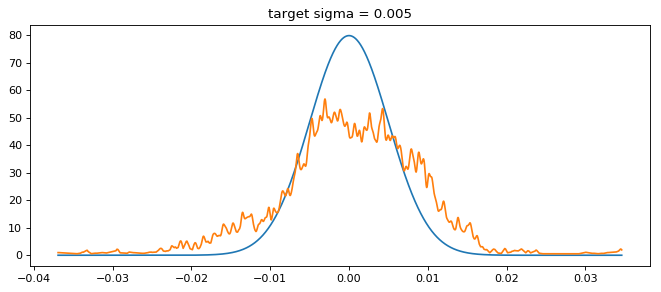

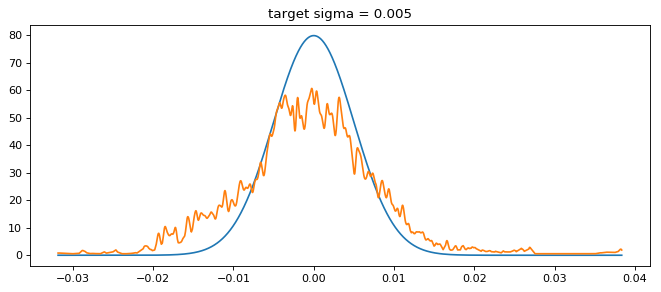

In [0]:
def report_perf(model_file_name):
  tsigma = 0.005
  x1, x2, y, _, _, _, _, _, _ = get_data_from_csv('zhiming_irreg.csv')
  x = merge_x1_x2(x1, x2)
  model = reload_model(model_file_name)
  errors, errors_mean, errors_sigma, errors_rel = get_errors(model, x, y)
  loss, dist, sd = get_loss_kde_include_mse(errors=errors, target_sigma=tsigma, if_plot=True)
  line = "\n--------------" + model_file_name
  print(line)
  print("loss:", loss, ", PDF loss:", dist)
  print("errors mean:", errors_mean, ", errors sigma:", errors_sigma)
  print("relative errors mean:", np.mean(errors_rel), ", relative errors sigma:", np.var(errors_rel))

model_file_name = 'model_benchmark_relative_errors_0.02119291809884263.h5'
report_perf(model_file_name)
model_file_name = 'model_best.h5'
report_perf(model_file_name)

### Plot from files

target_sigma: 0.001
loss_min_index: 95


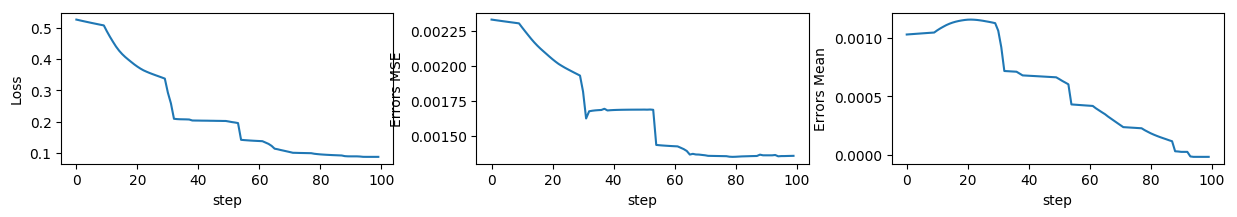

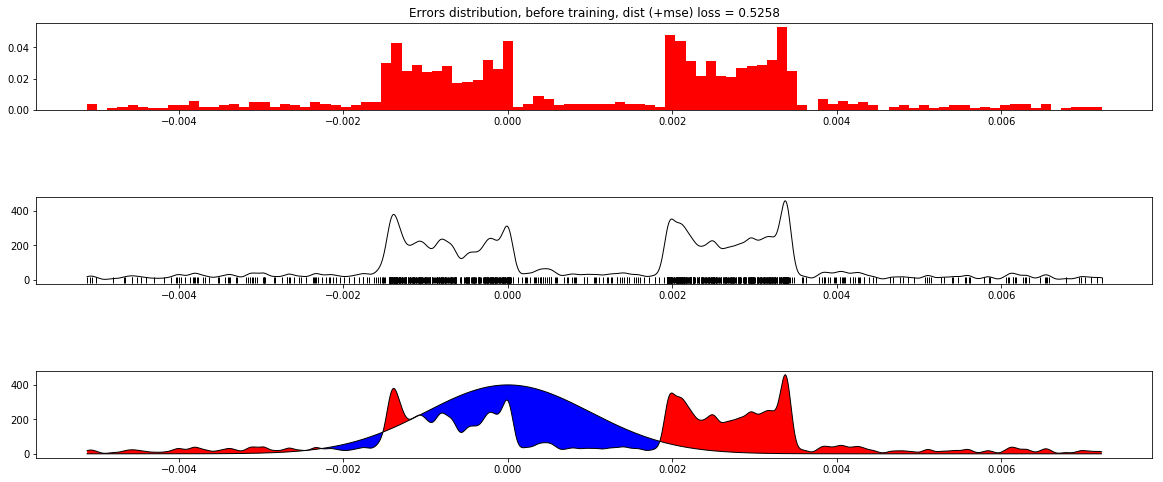

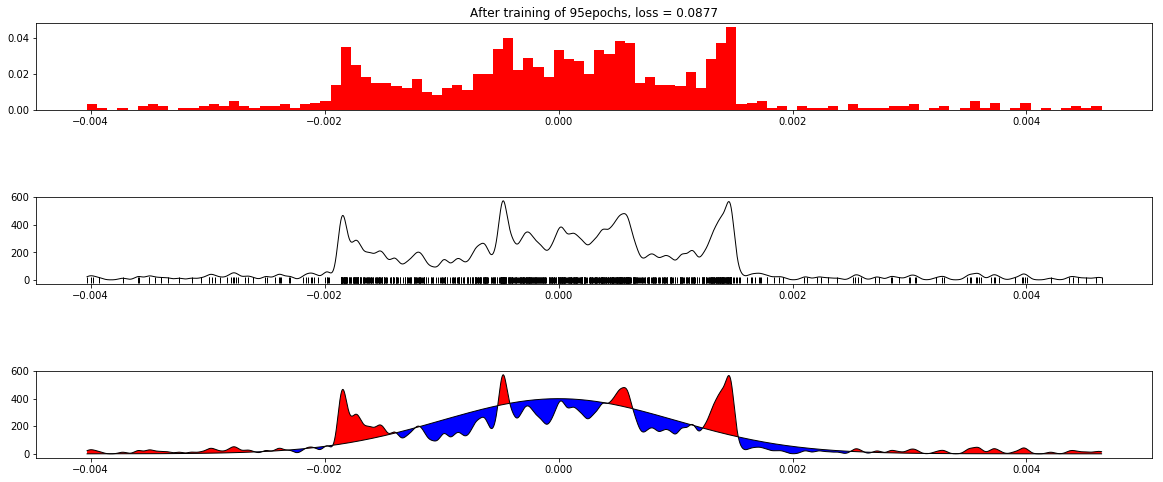

In [0]:
import re
def get_loss_dist_sd_errors_from_files(dir):
  losses=[]; dists=[]; sds=[]; errorses=[]
  files = [f for f in listdir(mypath) if isfile(join(mypath, f))]
  for f in files:
    if f[-3:] == 'txt':
      loss = re.search('loss[0-9]*.[0-9]*_', f)
      loss = float(loss[0][4:10])
      losses.append(loss)
      
      dist = re.search('dist[0-9]*.[0-9]*_', f)
      dist = float(dist[0][4:10])
      dists.append(dist)
      
      sd = re.search('sd[0-9]*.[0-9]*.', f)
      sd = float(sd[0][2:8])
      sds.append(sd)
      #print("loss:", loss, "dist:", dist, "sd:", sd)
      
      f = 'history/'+ f
      errors = read_list_from_txt(f)
      errorses.append(errors)
      
  return losses, dists, sds, errorses
    
def read_list_from_txt(file_name):
  with open(file_name) as f:
    content = f.readlines()
  content = [x.strip() for x in content]    
  content.pop(0)
  ls = [float(x) for x in content] 
  return ls

dir = '/content/gdrive/My Drive/Colab Notebooks/ckp/history'
losses, dists, sds, errorses = get_loss_dist_sd_errors_from_files(dir)
errors_mses = [np.sqrt(np.var(errors)) for errors in errorses]
errors_means = [np.mean(errors) for errors in errorses]
print_result(losses=losses, errors_all=errorses, errors_mses=errors_mses, errors_means=errors_means, target_sigma=0.001)

### Fluctuation in benchmark NN performence

read 90 rows from csv file
data size: 5785
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
a (Dense)                    (None, 5)                 15        
_________________________________________________________________
b (Dense)                    (None, 1)                 6         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


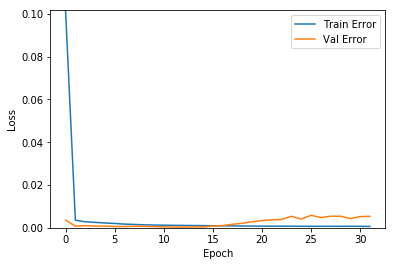

-------------------------------------- None
mean of errors: 0.011108333462069754
standard deviation of errors: 0.038254250888881076
--------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  import sys


read 90 rows from csv file
data size: 5785
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
a (Dense)                    (None, 5)                 15        
_________________________________________________________________
b (Dense)                    (None, 1)                 6         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


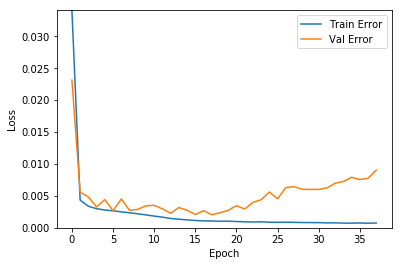

-------------------------------------- None
mean of errors: 0.02048004883529817
standard deviation of errors: 0.04405055895901456
--------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  import sys


read 90 rows from csv file
data size: 5785
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
a (Dense)                    (None, 5)                 15        
_________________________________________________________________
b (Dense)                    (None, 1)                 6         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


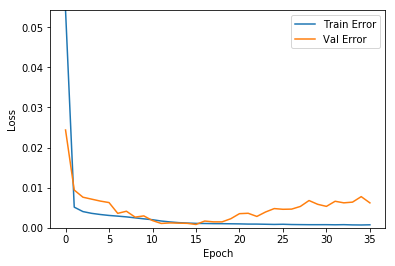

-------------------------------------- None
mean of errors: 0.015762357372370077
standard deviation of errors: 0.039261126079454256
--------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  import sys


read 90 rows from csv file
data size: 5785
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
a (Dense)                    (None, 5)                 15        
_________________________________________________________________
b (Dense)                    (None, 1)                 6         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


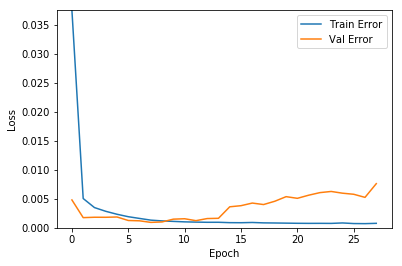

-------------------------------------- None
mean of errors: 0.015535888522549144
standard deviation of errors: 0.04301499795160892
--------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  import sys


read 90 rows from csv file
data size: 5785
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
a (Dense)                    (None, 5)                 15        
_________________________________________________________________
b (Dense)                    (None, 1)                 6         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


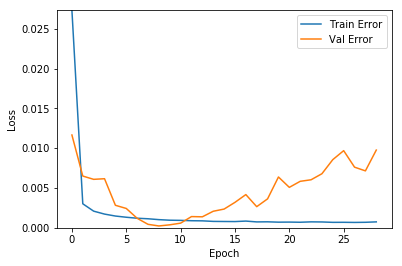

-------------------------------------- None
mean of errors: 0.01740914191661875
standard deviation of errors: 0.046383492597275144
--------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  import sys


read 90 rows from csv file
data size: 5785
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
a (Dense)                    (None, 5)                 15        
_________________________________________________________________
b (Dense)                    (None, 1)                 6         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


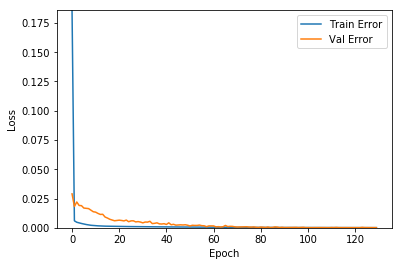

-------------------------------------- None
mean of errors: -0.004130088152386754
standard deviation of errors: 0.011686758520009416
--------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  import sys


read 90 rows from csv file
data size: 5785
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
a (Dense)                    (None, 5)                 15        
_________________________________________________________________
b (Dense)                    (None, 1)                 6         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


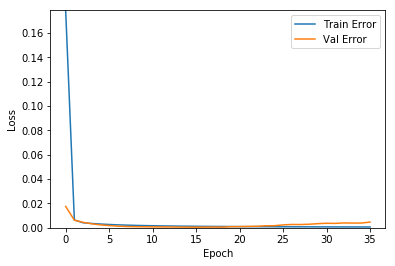

-------------------------------------- None
mean of errors: 0.013293674788932508
standard deviation of errors: 0.03619945681167878
--------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  import sys


read 90 rows from csv file
data size: 5785
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
a (Dense)                    (None, 5)                 15        
_________________________________________________________________
b (Dense)                    (None, 1)                 6         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


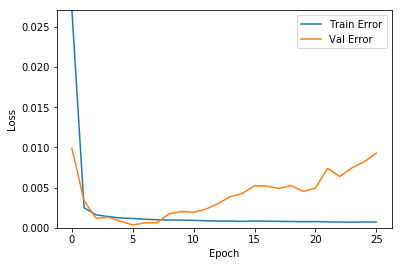

-------------------------------------- None
mean of errors: 0.0195355823327677
standard deviation of errors: 0.04575989900522107
--------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  import sys


read 90 rows from csv file
data size: 5785
Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
a (Dense)                    (None, 5)                 15        
_________________________________________________________________
b (Dense)                    (None, 1)                 6         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


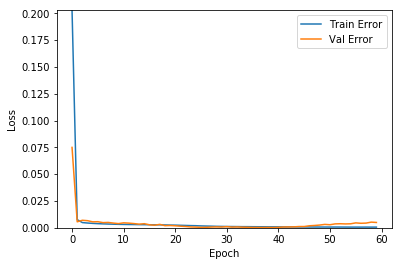

-------------------------------------- None
mean of errors: 0.015370628970361727
standard deviation of errors: 0.03529251821783952
--------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  import sys


read 90 rows from csv file
data size: 5785
Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
a (Dense)                    (None, 5)                 15        
_________________________________________________________________
b (Dense)                    (None, 1)                 6         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


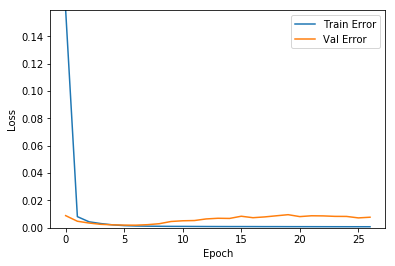

-------------------------------------- None
mean of errors: 0.01617661736687403
standard deviation of errors: 0.04363322682713094
--------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  import sys


read 90 rows from csv file
data size: 5785
Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
a (Dense)                    (None, 5)                 15        
_________________________________________________________________
b (Dense)                    (None, 1)                 6         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


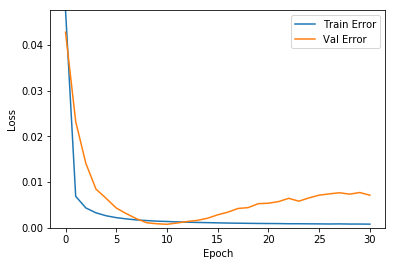

-------------------------------------- None
mean of errors: 0.011130128997734327
standard deviation of errors: 0.044147872289868065
--------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  import sys


read 90 rows from csv file
data size: 5785
Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
a (Dense)                    (None, 5)                 15        
_________________________________________________________________
b (Dense)                    (None, 1)                 6         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


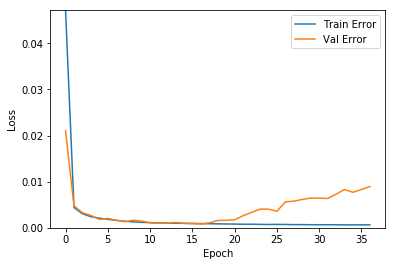

-------------------------------------- None
mean of errors: 0.018265716954815877
standard deviation of errors: 0.044288408354964025
--------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  import sys


read 90 rows from csv file
data size: 5785
Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
a (Dense)                    (None, 5)                 15        
_________________________________________________________________
b (Dense)                    (None, 1)                 6         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


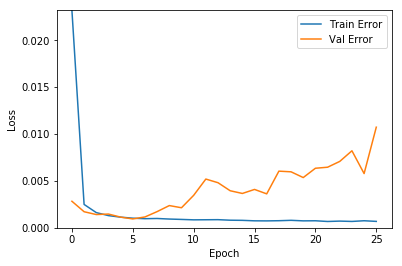

-------------------------------------- None
mean of errors: 0.017757703265828522
standard deviation of errors: 0.048978179689608645
--------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  import sys


read 90 rows from csv file
data size: 5785
Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
a (Dense)                    (None, 5)                 15        
_________________________________________________________________
b (Dense)                    (None, 1)                 6         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


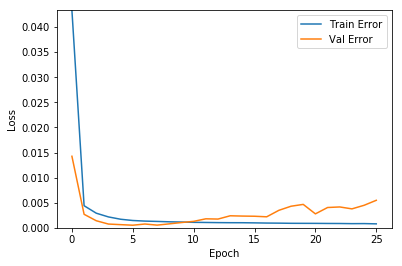

-------------------------------------- None
mean of errors: 0.011067962840773883
standard deviation of errors: 0.04006964679178321
--------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  import sys


read 90 rows from csv file
data size: 5785
Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
a (Dense)                    (None, 5)                 15        
_________________________________________________________________
b (Dense)                    (None, 1)                 6         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


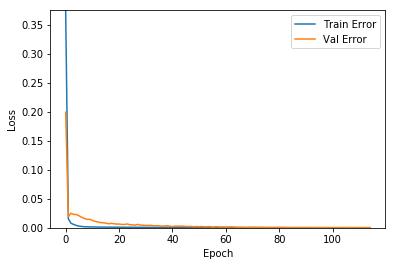

-------------------------------------- None
mean of errors: 0.0025288552404583407
standard deviation of errors: 0.013303977443822005
--------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  import sys


read 90 rows from csv file
data size: 5785
Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
a (Dense)                    (None, 5)                 15        
_________________________________________________________________
b (Dense)                    (None, 1)                 6         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


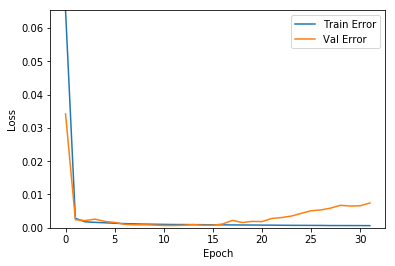

-------------------------------------- None
mean of errors: 0.017769725661774396
standard deviation of errors: 0.04127050144308653
--------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  import sys


read 90 rows from csv file
data size: 5785
Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
a (Dense)                    (None, 5)                 15        
_________________________________________________________________
b (Dense)                    (None, 1)                 6         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


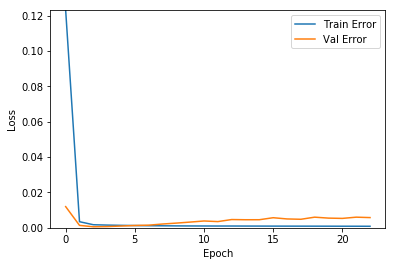

-------------------------------------- None
mean of errors: 0.01496242994911834
standard deviation of errors: 0.04021244089124346
--------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  import sys


read 90 rows from csv file
data size: 5785
Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
a (Dense)                    (None, 5)                 15        
_________________________________________________________________
b (Dense)                    (None, 1)                 6         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


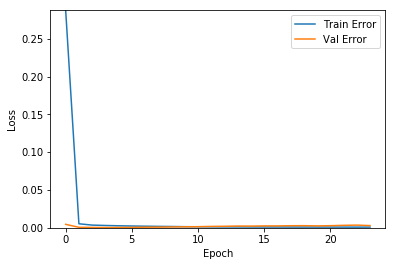

-------------------------------------- None
mean of errors: 0.009309029823680738
standard deviation of errors: 0.03461241063129299
--------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  import sys


read 90 rows from csv file
data size: 5785
Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
a (Dense)                    (None, 5)                 15        
_________________________________________________________________
b (Dense)                    (None, 1)                 6         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


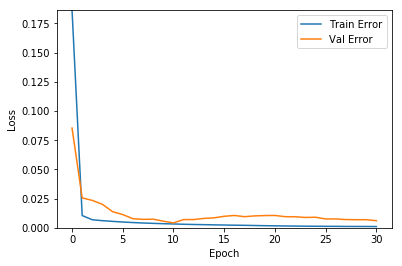

-------------------------------------- None
mean of errors: 0.011811433016244157
standard deviation of errors: 0.043884420376589066
--------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  import sys


read 90 rows from csv file
data size: 5785
Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
a (Dense)                    (None, 5)                 15        
_________________________________________________________________
b (Dense)                    (None, 1)                 6         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


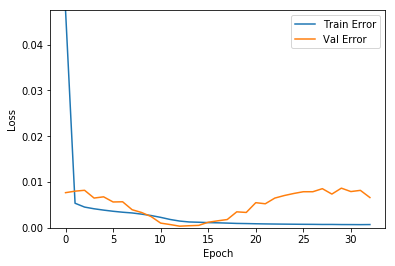

-------------------------------------- None
mean of errors: 0.02023800242490159
standard deviation of errors: 0.038868429229334006
--------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  import sys


read 90 rows from csv file
data size: 5785
Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
a (Dense)                    (None, 5)                 15        
_________________________________________________________________
b (Dense)                    (None, 1)                 6         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


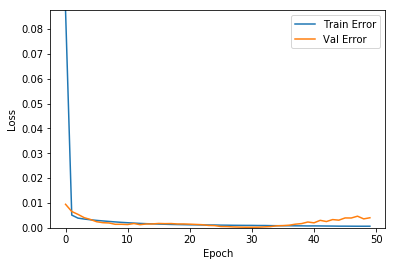

-------------------------------------- None
mean of errors: 0.01601766841523897
standard deviation of errors: 0.032902727535318366
--------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  import sys


read 90 rows from csv file
data size: 5785
Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
a (Dense)                    (None, 5)                 15        
_________________________________________________________________
b (Dense)                    (None, 1)                 6         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


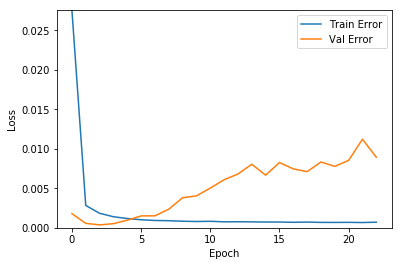

-------------------------------------- None
mean of errors: 0.019307745195733344
standard deviation of errors: 0.04435322741212212
--------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  import sys


read 90 rows from csv file
data size: 5785
Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
a (Dense)                    (None, 5)                 15        
_________________________________________________________________
b (Dense)                    (None, 1)                 6         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


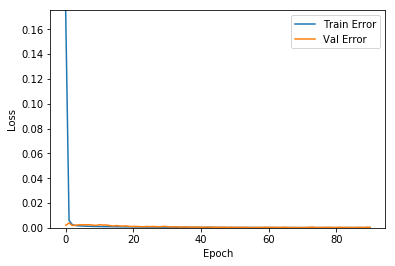

-------------------------------------- None
mean of errors: 0.0038291599126344346
standard deviation of errors: 0.013574961243058643
--------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  import sys


read 90 rows from csv file
data size: 5785
Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
a (Dense)                    (None, 5)                 15        
_________________________________________________________________
b (Dense)                    (None, 1)                 6         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


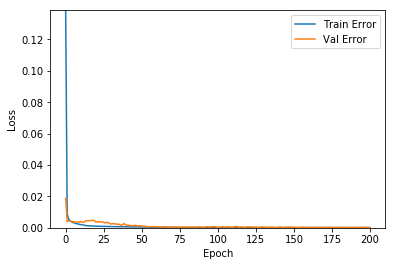

-------------------------------------- None
mean of errors: 0.002457657559245648
standard deviation of errors: 0.010608607442013484
--------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  import sys


read 90 rows from csv file
data size: 5785
Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
a (Dense)                    (None, 5)                 15        
_________________________________________________________________
b (Dense)                    (None, 1)                 6         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


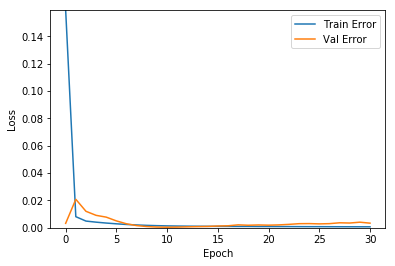

-------------------------------------- None
mean of errors: 0.007111696874281408
standard deviation of errors: 0.034807194412304995
--------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  import sys


read 90 rows from csv file
data size: 5785
Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
a (Dense)                    (None, 5)                 15        
_________________________________________________________________
b (Dense)                    (None, 1)                 6         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


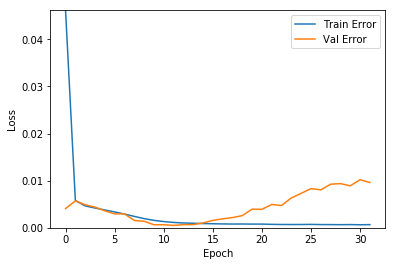

-------------------------------------- None
mean of errors: 0.016666818074471193
standard deviation of errors: 0.04653467736967747
--------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  import sys


read 90 rows from csv file
data size: 5785
Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
a (Dense)                    (None, 5)                 15        
_________________________________________________________________
b (Dense)                    (None, 1)                 6         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


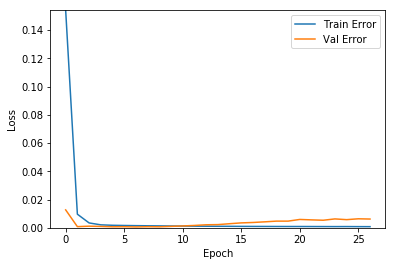

-------------------------------------- None
mean of errors: 0.01207896476929417
standard deviation of errors: 0.04177618165252781
--------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  import sys


read 90 rows from csv file
data size: 5785
Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
a (Dense)                    (None, 5)                 15        
_________________________________________________________________
b (Dense)                    (None, 1)                 6         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


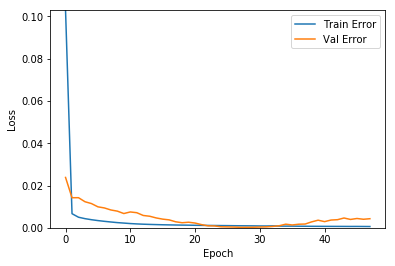

-------------------------------------- None
mean of errors: 0.012876816401547574
standard deviation of errors: 0.034251382581437805
--------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  import sys


read 90 rows from csv file
data size: 5785
Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
a (Dense)                    (None, 5)                 15        
_________________________________________________________________
b (Dense)                    (None, 1)                 6         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


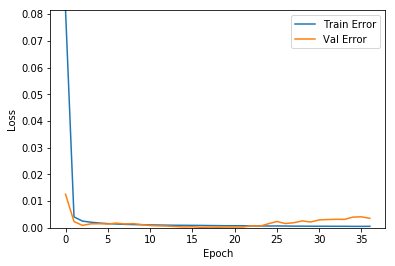

-------------------------------------- None
mean of errors: 0.015702440206326593
standard deviation of errors: 0.030414224497384977
--------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  import sys


read 90 rows from csv file
data size: 5785
Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
a (Dense)                    (None, 5)                 15        
_________________________________________________________________
b (Dense)                    (None, 1)                 6         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


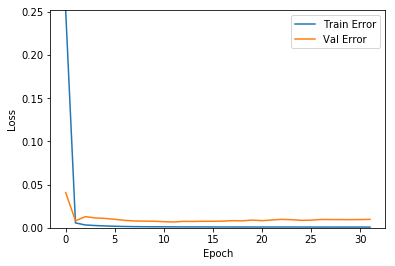

-------------------------------------- None
mean of errors: 0.019074305332850674
standard deviation of errors: 0.04734723149736272
--------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  import sys


read 90 rows from csv file
data size: 5785
Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
a (Dense)                    (None, 5)                 15        
_________________________________________________________________
b (Dense)                    (None, 1)                 6         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


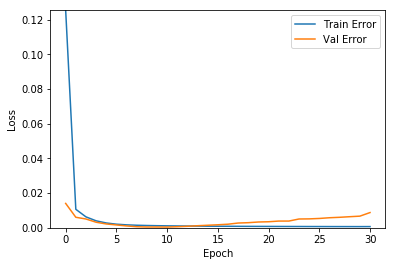

-------------------------------------- None
mean of errors: 0.015953669267341618
standard deviation of errors: 0.04536098294204268
--------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  import sys


read 90 rows from csv file
data size: 5785
Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
a (Dense)                    (None, 5)                 15        
_________________________________________________________________
b (Dense)                    (None, 1)                 6         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


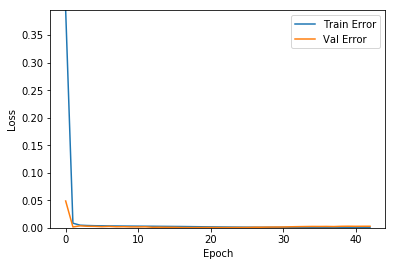

-------------------------------------- None
mean of errors: 0.007575542879465233
standard deviation of errors: 0.032024799829427034
--------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  import sys


read 90 rows from csv file
data size: 5785
Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
a (Dense)                    (None, 5)                 15        
_________________________________________________________________
b (Dense)                    (None, 1)                 6         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


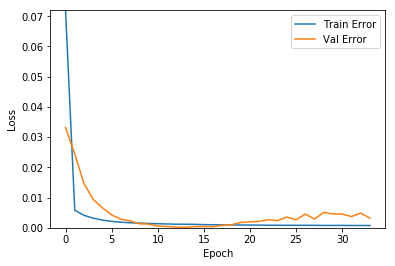

-------------------------------------- None
mean of errors: 0.0163461462266711
standard deviation of errors: 0.03302711147436789
--------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  import sys


read 90 rows from csv file
data size: 5785
Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
a (Dense)                    (None, 5)                 15        
_________________________________________________________________
b (Dense)                    (None, 1)                 6         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


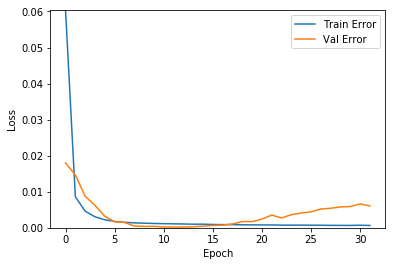

-------------------------------------- None
mean of errors: 0.010769408452964185
standard deviation of errors: 0.04030138846865704
--------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  import sys


read 90 rows from csv file
data size: 5785
Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
a (Dense)                    (None, 5)                 15        
_________________________________________________________________
b (Dense)                    (None, 1)                 6         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


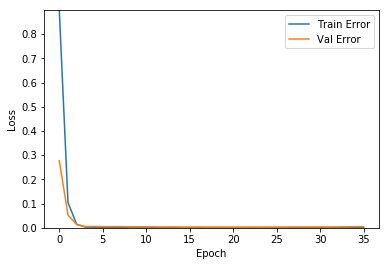

-------------------------------------- None
mean of errors: 0.00808988634410766
standard deviation of errors: 0.04089484918705041
--------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  import sys


read 90 rows from csv file
data size: 5785
Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
a (Dense)                    (None, 5)                 15        
_________________________________________________________________
b (Dense)                    (None, 1)                 6         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


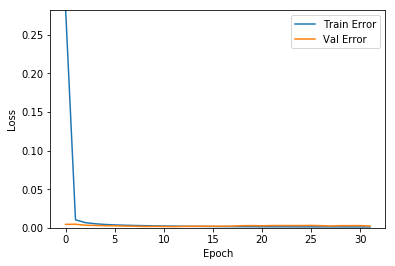

-------------------------------------- None
mean of errors: -0.001055852409602238
standard deviation of errors: 0.03628721299674694
--------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  import sys


read 90 rows from csv file
data size: 5785
Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
a (Dense)                    (None, 5)                 15        
_________________________________________________________________
b (Dense)                    (None, 1)                 6         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


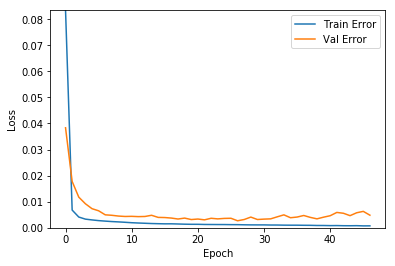

-------------------------------------- None
mean of errors: 0.016680089930851297
standard deviation of errors: 0.03703058726727888
--------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  import sys


read 90 rows from csv file
data size: 5785
Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
a (Dense)                    (None, 5)                 15        
_________________________________________________________________
b (Dense)                    (None, 1)                 6         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


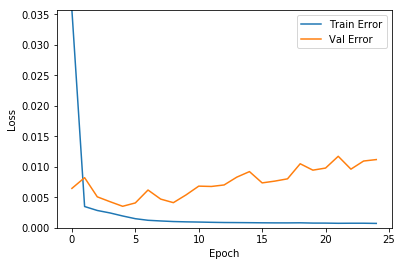

-------------------------------------- None
mean of errors: 0.020099041496790378
standard deviation of errors: 0.04894366784232008
--------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  import sys


read 90 rows from csv file
data size: 5785
Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
a (Dense)                    (None, 5)                 15        
_________________________________________________________________
b (Dense)                    (None, 1)                 6         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


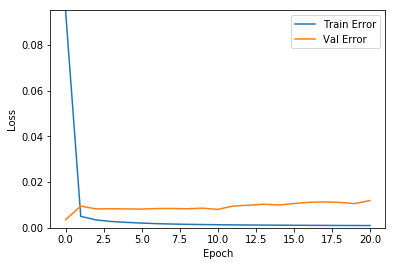

-------------------------------------- None
mean of errors: 0.021742134758101116
standard deviation of errors: 0.05180057250232794
--------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  import sys


read 90 rows from csv file
data size: 5785
Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
a (Dense)                    (None, 5)                 15        
_________________________________________________________________
b (Dense)                    (None, 1)                 6         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


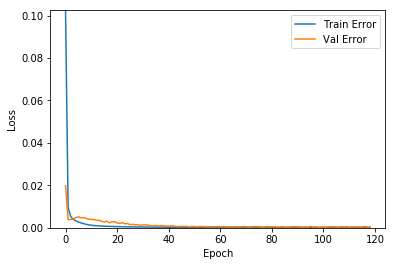

-------------------------------------- None
mean of errors: 0.002349691351653179
standard deviation of errors: 0.01293772640085031
--------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  import sys


read 90 rows from csv file
data size: 5785
Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
a (Dense)                    (None, 5)                 15        
_________________________________________________________________
b (Dense)                    (None, 1)                 6         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


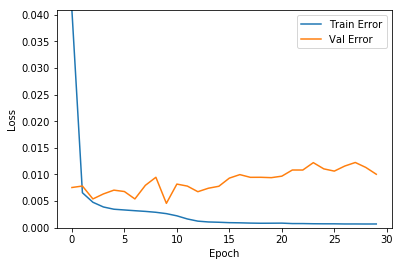

-------------------------------------- None
mean of errors: 0.021449173396861858
standard deviation of errors: 0.04602022056460094
--------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  import sys


read 90 rows from csv file
data size: 5785
Model: "sequential_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
a (Dense)                    (None, 5)                 15        
_________________________________________________________________
b (Dense)                    (None, 1)                 6         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


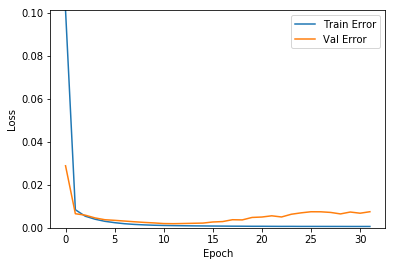

-------------------------------------- None
mean of errors: 0.01672608018057452
standard deviation of errors: 0.04118405211716749
--------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  import sys


read 90 rows from csv file
data size: 5785
Model: "sequential_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
a (Dense)                    (None, 5)                 15        
_________________________________________________________________
b (Dense)                    (None, 1)                 6         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


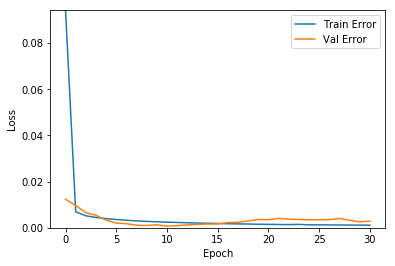

-------------------------------------- None
mean of errors: -0.012469324992644751
standard deviation of errors: 0.03625234303362333
--------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  import sys


read 90 rows from csv file
data size: 5785
Model: "sequential_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
a (Dense)                    (None, 5)                 15        
_________________________________________________________________
b (Dense)                    (None, 1)                 6         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


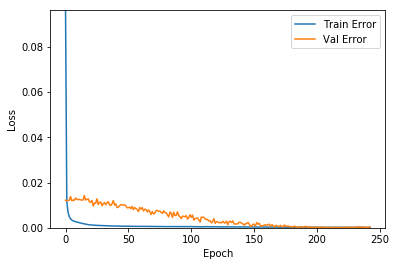

-------------------------------------- None
mean of errors: -0.0052668181777103425
standard deviation of errors: 0.013339109444476173
--------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  import sys


read 90 rows from csv file
data size: 5785
Model: "sequential_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
a (Dense)                    (None, 5)                 15        
_________________________________________________________________
b (Dense)                    (None, 1)                 6         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


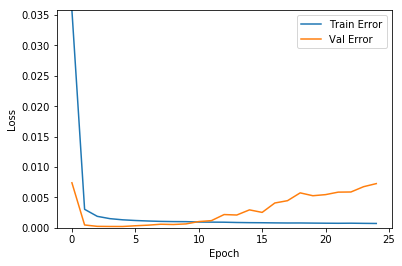

-------------------------------------- None
mean of errors: 0.016236023788856045
standard deviation of errors: 0.04191562496234957
--------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  import sys


read 90 rows from csv file
data size: 5785
Model: "sequential_52"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
a (Dense)                    (None, 5)                 15        
_________________________________________________________________
b (Dense)                    (None, 1)                 6         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


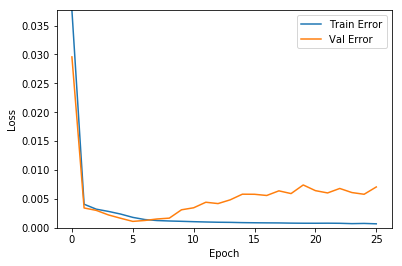

-------------------------------------- None
mean of errors: 0.014266638919950671
standard deviation of errors: 0.042014624775242114
--------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  import sys


read 90 rows from csv file
data size: 5785
Model: "sequential_53"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
a (Dense)                    (None, 5)                 15        
_________________________________________________________________
b (Dense)                    (None, 1)                 6         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


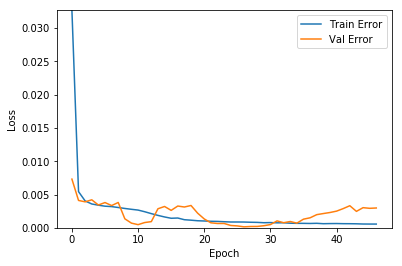

-------------------------------------- None
mean of errors: 0.012348944729035957
standard deviation of errors: 0.030057406387730877
--------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  import sys


read 90 rows from csv file
data size: 5785
Model: "sequential_54"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
a (Dense)                    (None, 5)                 15        
_________________________________________________________________
b (Dense)                    (None, 1)                 6         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


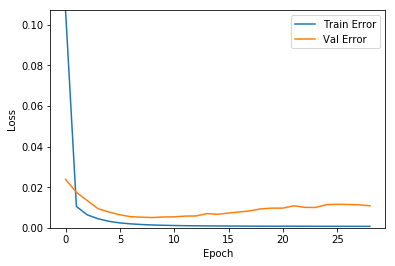

-------------------------------------- None
mean of errors: 0.018599352986079003
standard deviation of errors: 0.04885156499680195
--------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  import sys


read 90 rows from csv file
data size: 5785
Model: "sequential_55"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
a (Dense)                    (None, 5)                 15        
_________________________________________________________________
b (Dense)                    (None, 1)                 6         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


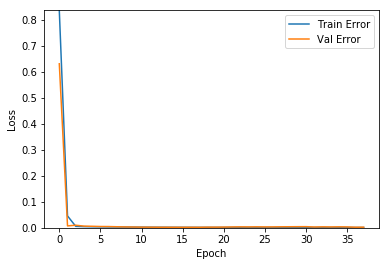

-------------------------------------- None
mean of errors: -0.003069391316221823
standard deviation of errors: 0.03718200367400555
--------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  import sys


read 90 rows from csv file
data size: 5785
Model: "sequential_56"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
a (Dense)                    (None, 5)                 15        
_________________________________________________________________
b (Dense)                    (None, 1)                 6         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


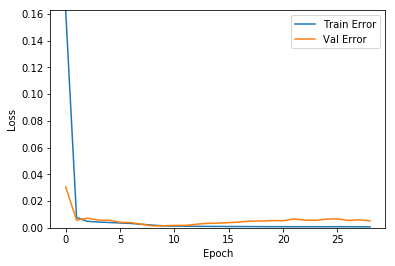

-------------------------------------- None
mean of errors: 0.013692003252666991
standard deviation of errors: 0.03761299808235179
--------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  import sys


read 90 rows from csv file
data size: 5785
Model: "sequential_57"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
a (Dense)                    (None, 5)                 15        
_________________________________________________________________
b (Dense)                    (None, 1)                 6         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


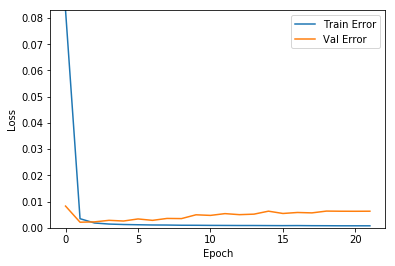

-------------------------------------- None
mean of errors: 0.014680406127773495
standard deviation of errors: 0.04043714449556211
--------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  import sys


read 90 rows from csv file
data size: 5785
Model: "sequential_58"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
a (Dense)                    (None, 5)                 15        
_________________________________________________________________
b (Dense)                    (None, 1)                 6         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


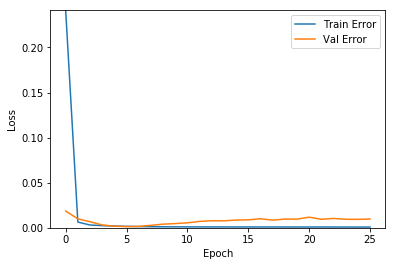

-------------------------------------- None
mean of errors: 0.018805716281238057
standard deviation of errors: 0.047324647911788593
--------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  import sys


read 90 rows from csv file
data size: 5785
Model: "sequential_59"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
a (Dense)                    (None, 5)                 15        
_________________________________________________________________
b (Dense)                    (None, 1)                 6         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


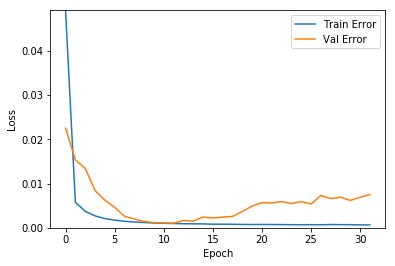

-------------------------------------- None
mean of errors: 0.015483359732160104
standard deviation of errors: 0.0420848577810274
--------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  import sys


read 90 rows from csv file
data size: 5785
Model: "sequential_60"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
a (Dense)                    (None, 5)                 15        
_________________________________________________________________
b (Dense)                    (None, 1)                 6         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


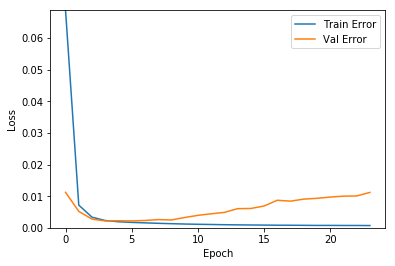

-------------------------------------- None
mean of errors: 0.016037413381118665
standard deviation of errors: 0.05066165099565548
--------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  import sys


read 90 rows from csv file
data size: 5785
Model: "sequential_61"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
a (Dense)                    (None, 5)                 15        
_________________________________________________________________
b (Dense)                    (None, 1)                 6         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


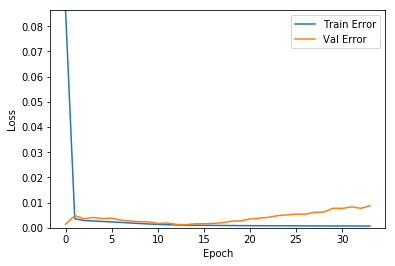

-------------------------------------- None
mean of errors: 0.015498034829730714
standard deviation of errors: 0.045567156187787144
--------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  import sys


read 90 rows from csv file
data size: 5785
Model: "sequential_62"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
a (Dense)                    (None, 5)                 15        
_________________________________________________________________
b (Dense)                    (None, 1)                 6         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


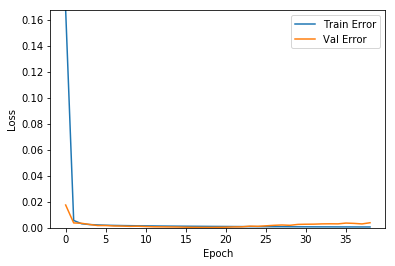

-------------------------------------- None
mean of errors: 0.006876355149278175
standard deviation of errors: 0.03567211848356796
--------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  import sys


read 90 rows from csv file
data size: 5785
Model: "sequential_63"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
a (Dense)                    (None, 5)                 15        
_________________________________________________________________
b (Dense)                    (None, 1)                 6         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


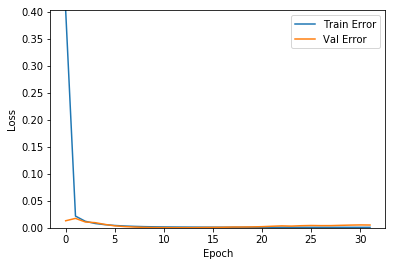

-------------------------------------- None
mean of errors: 0.010981441992845844
standard deviation of errors: 0.03967712641389863
--------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  import sys


read 90 rows from csv file
data size: 5785
Model: "sequential_64"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
a (Dense)                    (None, 5)                 15        
_________________________________________________________________
b (Dense)                    (None, 1)                 6         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


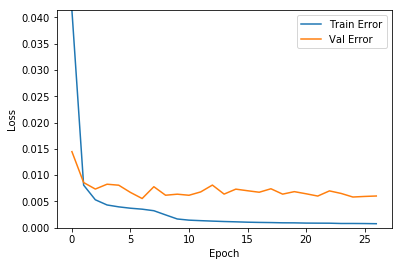

-------------------------------------- None
mean of errors: 0.021815753893462776
standard deviation of errors: 0.0374823329564191
--------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  import sys


read 90 rows from csv file
data size: 5785
Model: "sequential_65"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
a (Dense)                    (None, 5)                 15        
_________________________________________________________________
b (Dense)                    (None, 1)                 6         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


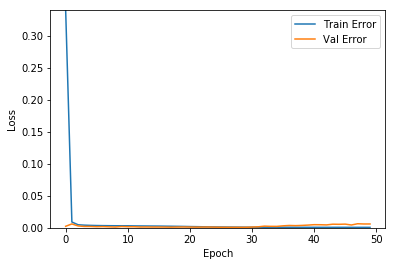

-------------------------------------- None
mean of errors: 0.014899213152108985
standard deviation of errors: 0.038964817866504145
--------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  import sys


read 90 rows from csv file
data size: 5785
Model: "sequential_66"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
a (Dense)                    (None, 5)                 15        
_________________________________________________________________
b (Dense)                    (None, 1)                 6         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


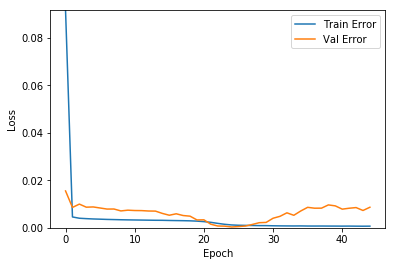

-------------------------------------- None
mean of errors: 0.015652160039799117
standard deviation of errors: 0.044893825330394495
--------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  import sys


read 90 rows from csv file
data size: 5785
Model: "sequential_67"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
a (Dense)                    (None, 5)                 15        
_________________________________________________________________
b (Dense)                    (None, 1)                 6         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


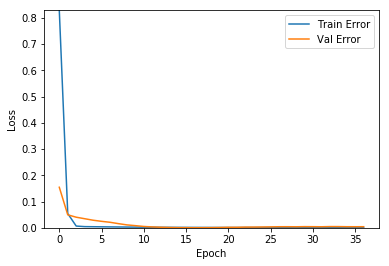

-------------------------------------- None
mean of errors: 0.013463152787730732
standard deviation of errors: 0.035507216887775035
--------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  import sys


read 90 rows from csv file
data size: 5785
Model: "sequential_68"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
a (Dense)                    (None, 5)                 15        
_________________________________________________________________
b (Dense)                    (None, 1)                 6         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


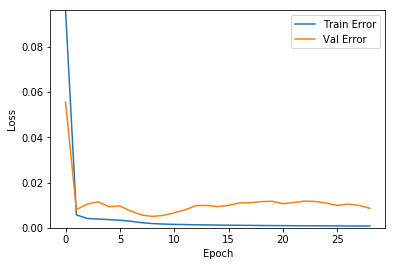

-------------------------------------- None
mean of errors: 0.015130071806742806
standard deviation of errors: 0.045767472440522566
--------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  import sys


read 90 rows from csv file
data size: 5785
Model: "sequential_69"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
a (Dense)                    (None, 5)                 15        
_________________________________________________________________
b (Dense)                    (None, 1)                 6         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


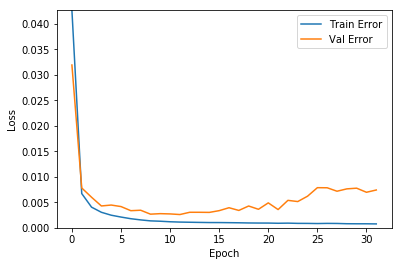

-------------------------------------- None
mean of errors: 0.018002862661453605
standard deviation of errors: 0.041894277658011
--------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  import sys


read 90 rows from csv file
data size: 5785
Model: "sequential_70"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
a (Dense)                    (None, 5)                 15        
_________________________________________________________________
b (Dense)                    (None, 1)                 6         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


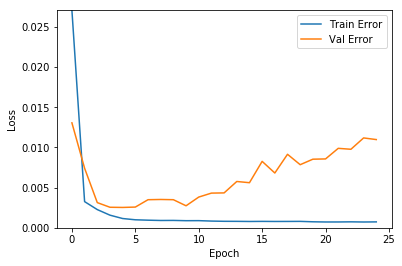

-------------------------------------- None
mean of errors: 0.017970414408003354
standard deviation of errors: 0.0496778859316848
--------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  import sys


read 90 rows from csv file
data size: 5785
Model: "sequential_71"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
a (Dense)                    (None, 5)                 15        
_________________________________________________________________
b (Dense)                    (None, 1)                 6         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


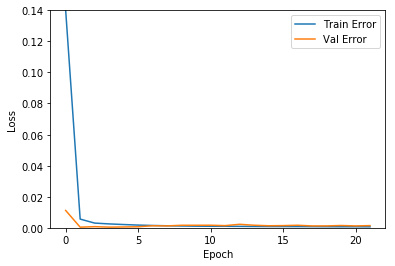

-------------------------------------- None
mean of errors: -0.008360901390135851
standard deviation of errors: 0.026410285949120833
--------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  import sys


read 90 rows from csv file
data size: 5785
Model: "sequential_72"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
a (Dense)                    (None, 5)                 15        
_________________________________________________________________
b (Dense)                    (None, 1)                 6         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


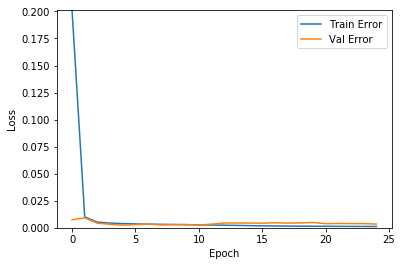

-------------------------------------- None
mean of errors: 0.00424817633589693
standard deviation of errors: 0.04007220525424389
--------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  import sys


read 90 rows from csv file
data size: 5785
Model: "sequential_73"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
a (Dense)                    (None, 5)                 15        
_________________________________________________________________
b (Dense)                    (None, 1)                 6         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


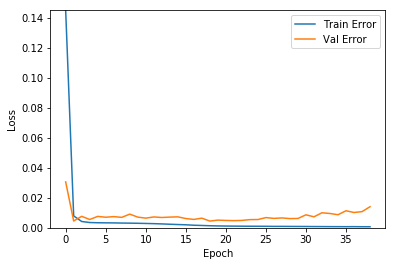

-------------------------------------- None
mean of errors: 0.03063070883274903
standard deviation of errors: 0.05086389951933404
--------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  import sys


read 90 rows from csv file
data size: 5785
Model: "sequential_74"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
a (Dense)                    (None, 5)                 15        
_________________________________________________________________
b (Dense)                    (None, 1)                 6         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


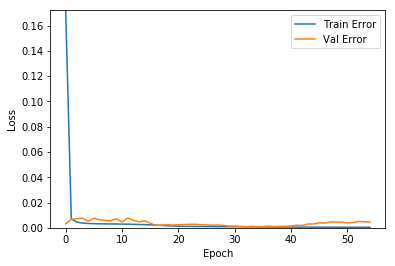

-------------------------------------- None
mean of errors: 0.017831691231331957
standard deviation of errors: 0.030838852331845645
--------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  import sys


read 90 rows from csv file
data size: 5785
Model: "sequential_75"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
a (Dense)                    (None, 5)                 15        
_________________________________________________________________
b (Dense)                    (None, 1)                 6         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


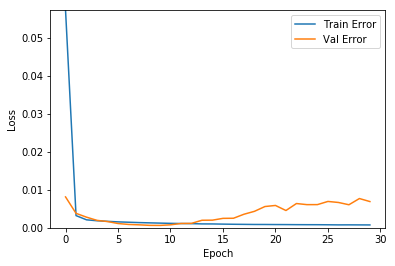

-------------------------------------- None
mean of errors: 0.017464372677770075
standard deviation of errors: 0.040950705102414366
--------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  import sys


read 90 rows from csv file
data size: 5785
Model: "sequential_76"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
a (Dense)                    (None, 5)                 15        
_________________________________________________________________
b (Dense)                    (None, 1)                 6         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


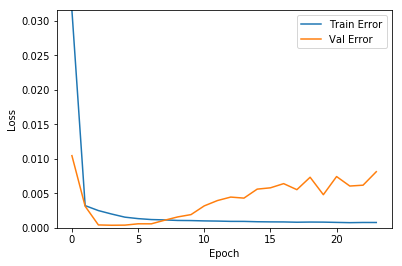

-------------------------------------- None
mean of errors: 0.01386409794431158
standard deviation of errors: 0.04541461788187665
--------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  import sys


read 90 rows from csv file
data size: 5785
Model: "sequential_77"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
a (Dense)                    (None, 5)                 15        
_________________________________________________________________
b (Dense)                    (None, 1)                 6         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


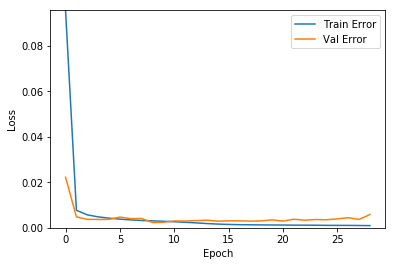

-------------------------------------- None
mean of errors: 0.011952631493447257
standard deviation of errors: 0.04238035782554378
--------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  import sys


read 90 rows from csv file
data size: 5785
Model: "sequential_78"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
a (Dense)                    (None, 5)                 15        
_________________________________________________________________
b (Dense)                    (None, 1)                 6         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


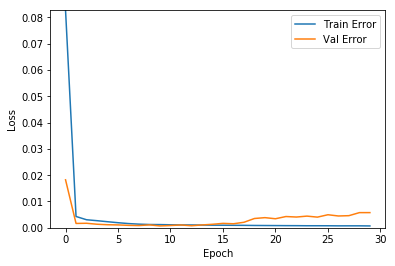

-------------------------------------- None
mean of errors: 0.01613277571519697
standard deviation of errors: 0.03814556798646002
--------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  import sys


read 90 rows from csv file
data size: 5785
Model: "sequential_79"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
a (Dense)                    (None, 5)                 15        
_________________________________________________________________
b (Dense)                    (None, 1)                 6         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


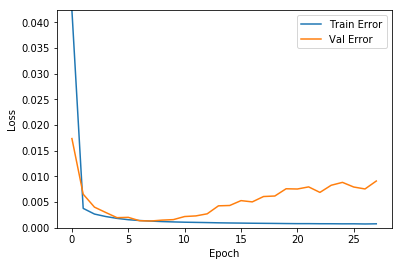

-------------------------------------- None
mean of errors: 0.013865202875073455
standard deviation of errors: 0.047665093271407354
--------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  import sys


read 90 rows from csv file
data size: 5785
Model: "sequential_80"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
a (Dense)                    (None, 5)                 15        
_________________________________________________________________
b (Dense)                    (None, 1)                 6         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


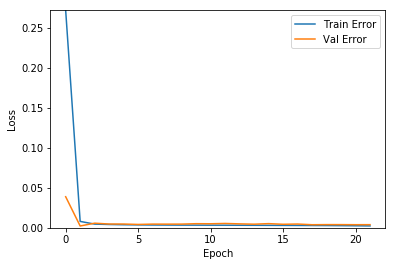

-------------------------------------- None
mean of errors: 0.014110533731933703
standard deviation of errors: 0.04869564177108891
--------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  import sys


read 90 rows from csv file
data size: 5785
Model: "sequential_81"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
a (Dense)                    (None, 5)                 15        
_________________________________________________________________
b (Dense)                    (None, 1)                 6         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


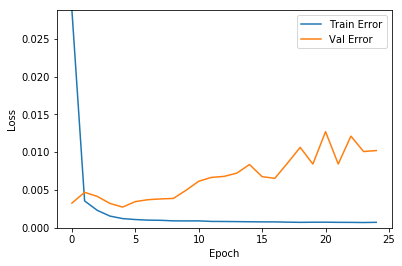

-------------------------------------- None
mean of errors: 0.018032726394141045
standard deviation of errors: 0.04739514953558794
--------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  import sys


read 90 rows from csv file
data size: 5785
Model: "sequential_82"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
a (Dense)                    (None, 5)                 15        
_________________________________________________________________
b (Dense)                    (None, 1)                 6         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


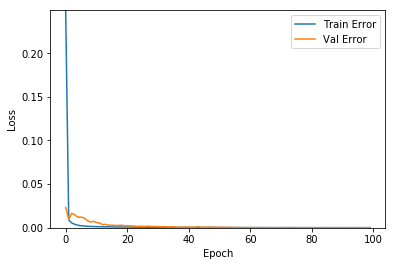

-------------------------------------- None
mean of errors: -0.002480970337438292
standard deviation of errors: 0.011034162465324151
--------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  import sys


read 90 rows from csv file
data size: 5785
Model: "sequential_83"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
a (Dense)                    (None, 5)                 15        
_________________________________________________________________
b (Dense)                    (None, 1)                 6         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


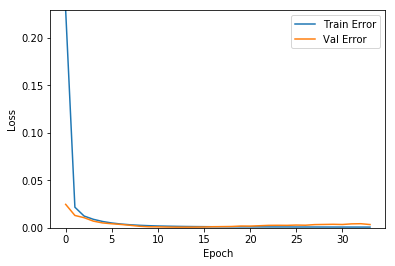

-------------------------------------- None
mean of errors: 0.01049233751357787
standard deviation of errors: 0.034228262379545966
--------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  import sys


read 90 rows from csv file
data size: 5785
Model: "sequential_84"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
a (Dense)                    (None, 5)                 15        
_________________________________________________________________
b (Dense)                    (None, 1)                 6         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


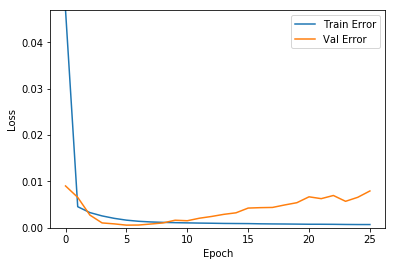

-------------------------------------- None
mean of errors: 0.020615135587714523
standard deviation of errors: 0.04145340557251744
--------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  import sys


read 90 rows from csv file
data size: 5785
Model: "sequential_85"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
a (Dense)                    (None, 5)                 15        
_________________________________________________________________
b (Dense)                    (None, 1)                 6         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


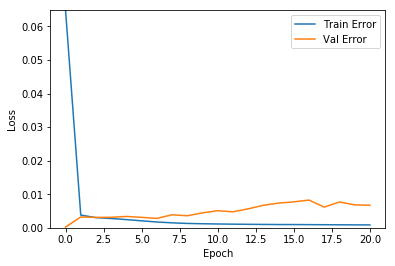

-------------------------------------- None
mean of errors: 0.017417894570211354
standard deviation of errors: 0.04156393834238946
--------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  import sys


read 90 rows from csv file
data size: 5785
Model: "sequential_86"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
a (Dense)                    (None, 5)                 15        
_________________________________________________________________
b (Dense)                    (None, 1)                 6         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


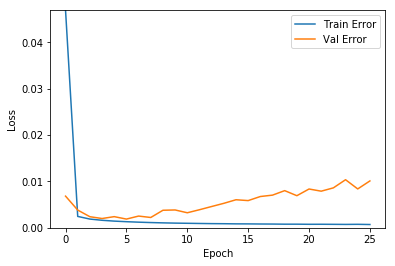

-------------------------------------- None
mean of errors: 0.01830436142727334
standard deviation of errors: 0.0473659727069924
--------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  import sys


read 90 rows from csv file
data size: 5785
Model: "sequential_87"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
a (Dense)                    (None, 5)                 15        
_________________________________________________________________
b (Dense)                    (None, 1)                 6         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


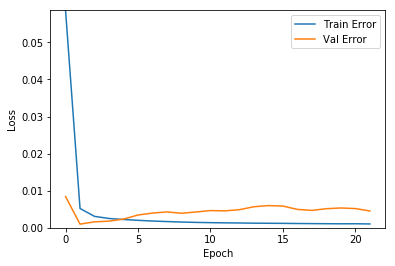

-------------------------------------- None
mean of errors: 0.012451989526128401
standard deviation of errors: 0.03958893032635023
--------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  import sys


read 90 rows from csv file
data size: 5785
Model: "sequential_88"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
a (Dense)                    (None, 5)                 15        
_________________________________________________________________
b (Dense)                    (None, 1)                 6         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


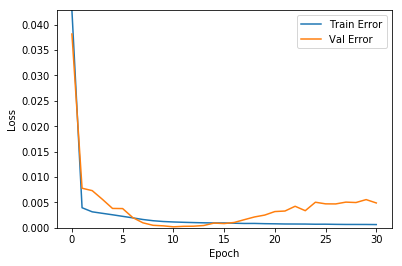

-------------------------------------- None
mean of errors: 0.006676138615309423
standard deviation of errors: 0.038250605922100694
--------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  import sys


read 90 rows from csv file
data size: 5785
Model: "sequential_89"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
a (Dense)                    (None, 5)                 15        
_________________________________________________________________
b (Dense)                    (None, 1)                 6         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


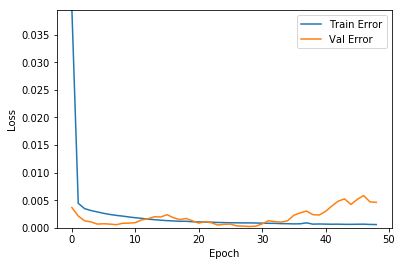

-------------------------------------- None
mean of errors: 0.013354805969450122
standard deviation of errors: 0.03438969930988984
--------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  import sys


read 90 rows from csv file
data size: 5785
Model: "sequential_90"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
a (Dense)                    (None, 5)                 15        
_________________________________________________________________
b (Dense)                    (None, 1)                 6         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


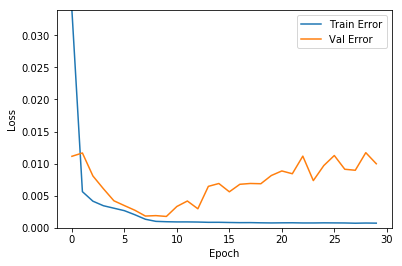

-------------------------------------- None
mean of errors: 0.019132121411983376
standard deviation of errors: 0.046712354997951545
--------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  import sys


read 90 rows from csv file
data size: 5785
Model: "sequential_91"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
a (Dense)                    (None, 5)                 15        
_________________________________________________________________
b (Dense)                    (None, 1)                 6         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


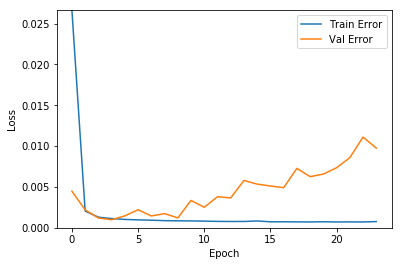

-------------------------------------- None
mean of errors: 0.015436499346065032
standard deviation of errors: 0.047770067572525096
--------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  import sys


read 90 rows from csv file
data size: 5785
Model: "sequential_92"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
a (Dense)                    (None, 5)                 15        
_________________________________________________________________
b (Dense)                    (None, 1)                 6         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


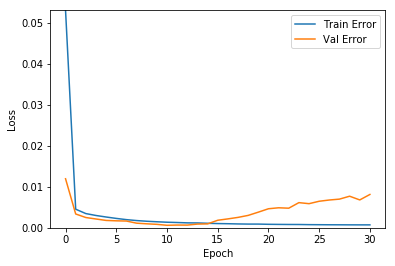

-------------------------------------- None
mean of errors: 0.012207378660664034
standard deviation of errors: 0.04576383528637291
--------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  import sys


read 90 rows from csv file
data size: 5785
Model: "sequential_93"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
a (Dense)                    (None, 5)                 15        
_________________________________________________________________
b (Dense)                    (None, 1)                 6         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


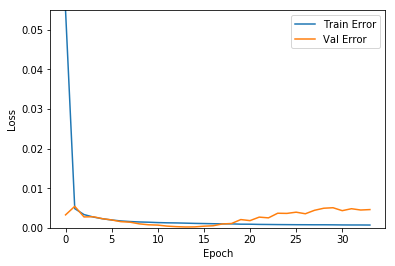

-------------------------------------- None
mean of errors: 0.014962047360194795
standard deviation of errors: 0.03530067084471874
--------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  import sys


read 90 rows from csv file
data size: 5785
Model: "sequential_94"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
a (Dense)                    (None, 5)                 15        
_________________________________________________________________
b (Dense)                    (None, 1)                 6         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


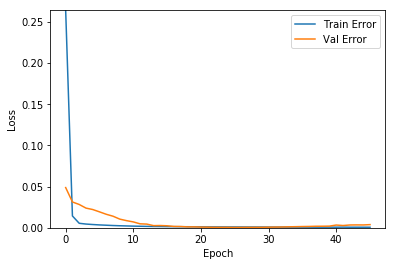

-------------------------------------- None
mean of errors: 0.012280057834126156
standard deviation of errors: 0.03400189191101365
--------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  import sys


read 90 rows from csv file
data size: 5785
Model: "sequential_95"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
a (Dense)                    (None, 5)                 15        
_________________________________________________________________
b (Dense)                    (None, 1)                 6         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


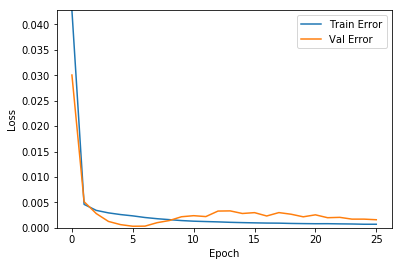

-------------------------------------- None
mean of errors: -0.006013694542903987
standard deviation of errors: 0.0284532903185256
--------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  import sys


read 90 rows from csv file
data size: 5785
Model: "sequential_96"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
a (Dense)                    (None, 5)                 15        
_________________________________________________________________
b (Dense)                    (None, 1)                 6         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


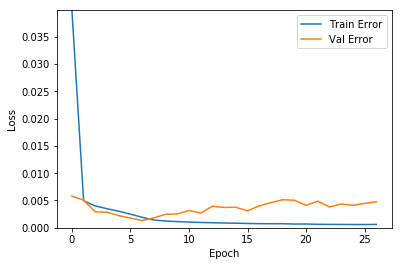

-------------------------------------- None
mean of errors: 0.012599629132646681
standard deviation of errors: 0.03521259629953179
--------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  import sys


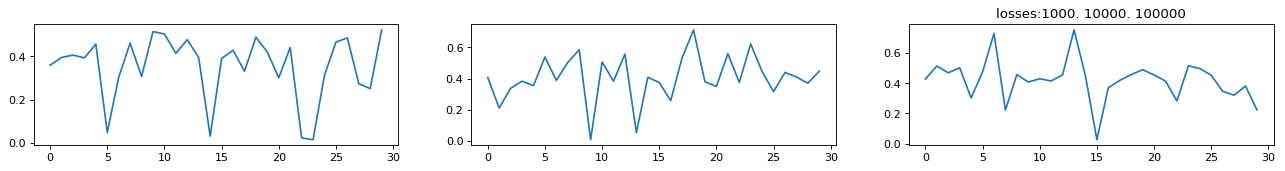

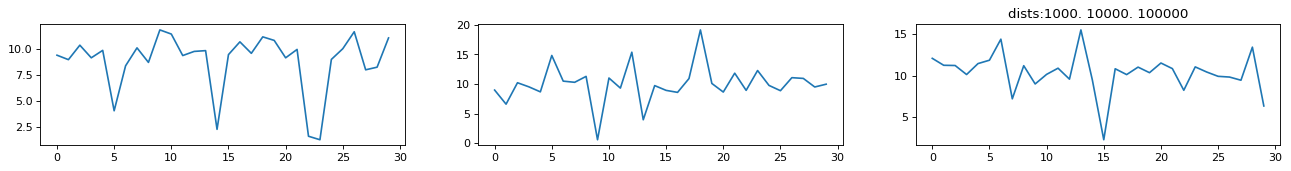

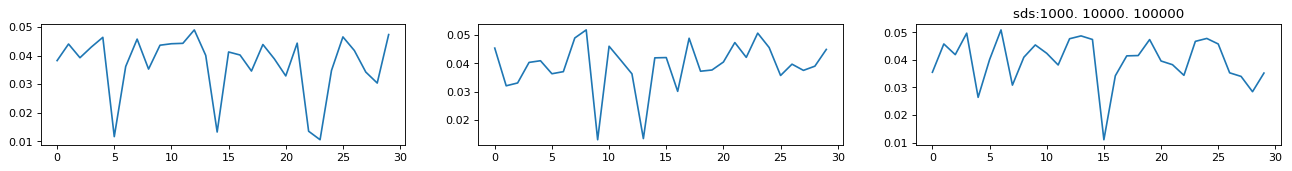

In [0]:
initial_losses_1000, initial_dists_1000, initial_sds_1000 = sample_initial_loss(sample_times=30, data_size=1000, tsigma=0.01)
initial_losses_10000, initial_dists_10000, initial_sds_10000 = sample_initial_loss(sample_times=30, data_size=10000, tsigma=0.01)
initial_losses_100000, initial_dists_100000, initial_sds_100000 = sample_initial_loss(sample_times=30, data_size=100000, tsigma=0.01)

save_txt('initial_losses_1000.txt', initial_losses_1000)
save_txt('initial_losses_10000.txt', initial_losses_10000)
save_txt('initial_losses_100000.txt', initial_losses_100000)
save_txt('initial_dists_1000.txt', initial_dists_1000)
save_txt('initial_dists_10000.txt', initial_dists_10000)
save_txt('initial_dists_100000.txt', initial_dists_100000)
save_txt('initial_sds_1000.txt', initial_sds_1000)
save_txt('initial_sds_10000.txt', initial_sds_10000)
save_txt('initial_sds_100000.txt', initial_sds_100000)

list_of_lists = [initial_losses_1000, initial_losses_10000, initial_losses_100000]
plot_lists(list_of_lists, 'losses:1000. 10000. 100000')
list_of_lists = [initial_dists_1000, initial_dists_10000, initial_dists_100000]
plot_lists(list_of_lists, 'dists:1000. 10000. 100000')
list_of_lists = [initial_sds_1000, initial_sds_10000, initial_sds_100000]
plot_lists(list_of_lists, 'sds:1000. 10000. 100000')

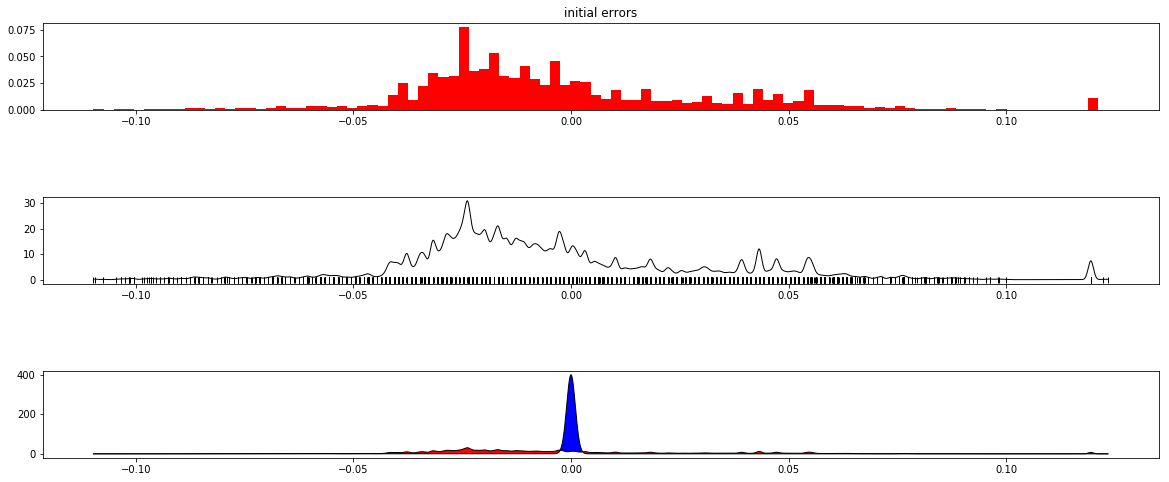

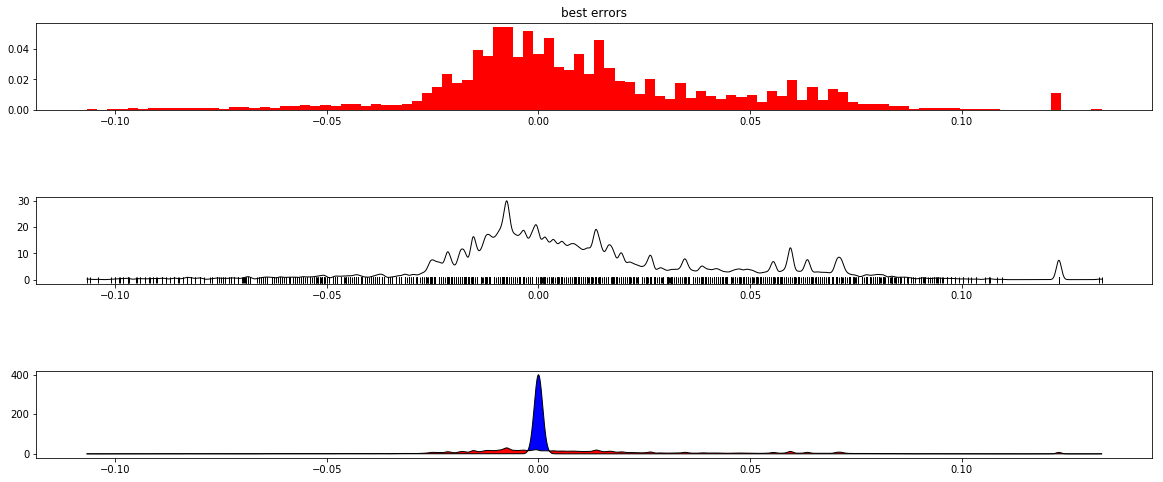

In [0]:
model = reload_model('model_best.h5')
